# Modificaciones ARIADNE

## Modelo

En `sed_fitting.py`, la función `model_grid` contiene el modelo que se ajusta. Por defecto es

$$ M = F \times \frac{R}{D}^2 $$

Que es justamente lo que [utiliza VOSA](http://svo2.cab.inta-csic.es/theory/vosa/helpw4.php?otype=star&action=help&what=fitbin) pero en el caso de una estrella. Es decir, hay que modificarlo a 

$$ M = F_1 \times \frac{R_1}{D}^2 + F_2 \times \frac{R_2}{D}^2 $$

Esto implica tener dos parámetros para el radio, además de duplicar los que necesite la función del flujo, para generar $F_2$

## Fit

Esta parte en principio no debería modificarse. Lo normal es que ARIADNE haga el BMA y todo lo que hace usualmente, pero por ahora no hay intenciones de cambiar eso. En el futuro sería deseable calcular la evidencia del modelo binario vs el single, si es que no hay una forma más eficiente de comparar modelos.

Lo que hace es obtener los residuos con `get_residuals`, que también devuelve los errores. Con esto se construye el likelihood via `log_likelihood`

Por tanto, lo que parece ser ideal es generar otra función `model_grid` al menos, que considere el caso binario. Luego queda ver si es necesario clonar las otras funciones para generar el likelihood o si se puede ser más directo.

## Pruebas

Para comenzar a ver si está funcionando bien y ser más eficientes en tiempo, partir por ajustar solo un parámetro y dejar los otros fijos. Verificar si se recupera el resultado correcto, comparar con caso single.

Ojalá recuperar los valores de la literatura para un sistema binario bien caracterizado, comparar qué tan cerca da, errores, etc.

## Dudas
ARIADNE permite dejar el radio fijo? Y otros valores como teff, logg, z? Me parece que si, hay que revisar la parte de los priors.

Podré ejecutar todo esto acá para hacer pruebas? Sin tener que modificar el codigo y reinstalar. Me parece que también sí, mientras pueda importar las funciones necesarias.

In [3]:
import numpy as np
import numba as nb
from astroARIADNE.star import Star

#V* V1334 Cyg
#ra = 319.8424131369400
#dec = 38.2374635626800
#starname = 'V* V1334 Cyg'
#gaia_id = 1964855904803120640

#OGLE LMC-CEP-144 (No params)
#ra = 72.5020950102900
#dec = -66.7316936244600
#starname = 'OGLE LMC-CEP-144'
#gaia_id = 4662508302029459456

#OGLE LMC-CEP-0227 (Paper)
#ra = 73.0654083127800
#dec = -70.2420117717800
#starname = 'LMC-CEP-0227'
#gaia_id = 4654937339840486528

#OGLE LMC-CEP-4506 (Paper)
ra = 88.3723247038500
dec = -67.8998225948200
starname = 'LMC-CEP-4506'
gaia_id = 4659220384315198208

#Ejemplo
#ra = 75.795
#dec = -30.399
#starname = 'NGTS-6'
#gaia_id = 4875693023844840448

s = Star(starname, ra, dec, g_id=gaia_id)

Holoviews not imported. Some visualizations will not be available.



		#####################################
		##             ARIADNE             ##
		#####################################
   spectrAl eneRgy dIstribution bAyesian moDel averagiNg fittEr

			Author : Jose Vines
			Contact : jose . vines at ug . uchile . cl
			Star : LMC-CEP-4506
		*** LOOKING UP ARCHIVAL INFORMATION ***
INFO: Query finished. [astroquery.utils.tap.core]
Warning!: CatalogWarning
Warning message: Parameter radius not found! Be advised.
Warning!: CatalogWarning
Warning message: Parameter lum not found! Be advised.
INFO: Query finished. [astroquery.utils.tap.core]
Star not found in catalog TYCHO2.
INFO: Query finished. [astroquery.utils.tap.core]
Star not found in catalog Pan-STARRS.
INFO: Query finished. [astroquery.utils.tap.core]
Star not found in catalog SDSS.
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
Looking online for archival magnitudes for star LMC-CEP-4506
Chec

In [4]:
mask = s.filter_mask
flxs = s.flux[mask]
flux = s.flux[mask]
errs = s.flux_er[mask]
filts = s.filter_names[mask]
wave = s.wave[mask]

print(filts)
print(flxs)
print(wave)

['SkyMapper_u' 'SkyMapper_v' 'GROUND_JOHNSON_B' 'SDSS_g' 'SkyMapper_g'
 'GaiaDR2v2_BP' 'GROUND_JOHNSON_V' 'SkyMapper_r' 'SDSS_r' 'GaiaDR2v2_G'
 'SDSS_i' 'SkyMapper_i' 'GaiaDR2v2_RP' 'TESS' 'SkyMapper_z' '2MASS_J'
 '2MASS_H' '2MASS_Ks' 'WISE_RSR_W1' 'WISE_RSR_W2']
[4.94698925e-12 1.59112713e-11 2.50227457e-11 2.61784593e-11
 2.29941314e-11 2.18398728e-11 2.51626667e-11 1.78008957e-11
 2.26419552e-11 1.83396263e-11 1.60373367e-11 1.02116928e-11
 1.49478873e-11 1.44147134e-11 6.51685643e-12 5.87036750e-12
 2.87291609e-12 1.20377174e-12 2.29843186e-13 6.57438912e-14]
[0.34966161 0.38377117 0.43475261 0.47188722 0.50994365 0.51289652
 0.5504666  0.61572835 0.61851945 0.64249309 0.74997042 0.77783747
 0.7799195  0.79723607 0.91617123 1.2408376  1.65136646 2.16558387
 3.37919135 4.62929607]


(0.1, 6.0)

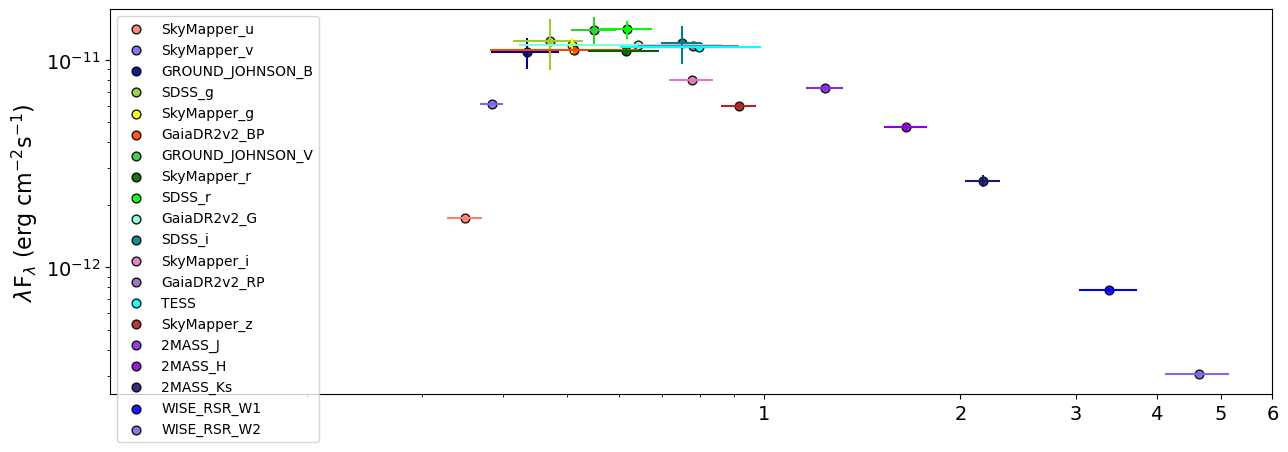

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

ymin = (flxs * wave).min()
ymax = (flxs * wave).max()

f, ax = plt.subplots(figsize=[15,5])

# Model plot
used_f = s.filter_names[mask]

colors = np.array(['tomato', 'indianred', 'tab:red',
            'salmon', 'coral',
            'mediumorchid', 'mediumslateblue', 'tab:blue',
            'darkslateblue', 'darkblue',
            'olivedrab', 'yellowgreen', 'greenyellow', 'yellow',
            'orangered', 'chocolate', 'khaki',
            'limegreen', 'darkgreen', 'lime', 'seagreen', 'lawngreen', 'green',
            'aquamarine', 'turquoise', 'lightseagreen', 'teal', 'cadetblue',
            'tab:pink', 'tab:purple', 'tab:cyan', 'aqua', 'azure', 'dodgerblue',
            'firebrick', 'darkred',
            'blueviolet', 'darkviolet',
            'midnightblue', 'blue',
            'deeppink', 'fuchsia', 'mediumslateblue'])

for c, w, fl, fe, bp, fi in zip(
                colors[mask],
                wave, flxs, errs,
                s.bandpass[mask], filts):
    ax.errorbar(w, fl * w, xerr=bp, yerr=fe * w, fmt='', ecolor=c, marker=None)

    ax.scatter(w, fl * w, edgecolors='black', marker='o', c=c, s=40,
               alpha=.9, label=fi)

ax.set_ylim([ymin * .8, ymax * 1.25])
ax.set_xscale('log', nonpositive='clip')
ax.set_yscale('log', nonpositive='clip')
ax.set_ylabel(r'$\lambda$F$_\lambda$ (erg cm$^{-2}$s$^{-1}$)', fontsize=16)
ax.legend(loc=0)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor')
ax.set_xticks(np.linspace(1, 10, 10))
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.1, 6])

#for tick in ax.get_yticklabels():
#    tick.set_fontname(self.fontname)

In [6]:
from astroARIADNE.config import (filesdir, gridsdir, modelsdir)
from isochrones.interp import DFInterpolator
import pandas as pd

params4506 = [28.5, 26.4, 2.087, 2.142, 6120, 6070, 0.01, 0.01]

'''
for OGLE...
rad1 = 34.87 #RSun
rad2 = 44.79
logg1 = 1.970 #cgs
logg2 = 1.743
teff1 = 6000 #K
teff2 = 5100
z1 = 0.01 #Not found
z2 = 0.01
#dist = 11601 #Retrieval
'''
rad1, rad2, logg1, logg2, teff1, teff2, z1, z2 = params4506
dist = 48500 #Google?


intp = open(gridsdir + '/Phoenixv2_DF.pkl', 'rb')
#intp = open(gridsdir + '/Coelho_DF.pkl', 'rb')
interpolator = DFInterpolator(pd.read_pickle(intp))

In [13]:
from extinction import apply
import extinction

def get_interpolated_flux(temp, logg, z, filts, interpolators):
    """Interpolate the grid of fluxes in a given teff, logg and z.
    Parameters
    ----------
    temp: float
        The effective temperature.
    logg: float
        The superficial gravity.
    z: float
        The metallicity.
    filts: str
        The desired filter.
    Returns
    -------
    flux : float
        The interpolated flux at temp, logg, z for filter filt.
    """
    values = (logg, temp, z)
    flux = interpolators(values, filts)
    return flux

def get_residuals(theta, flux, flux_er, wave, filts, interpolators, use_norm,
                  av_law):
    """Calculate residuals of the model."""
    model = binary_model_grid(theta, filts, wave, interpolators, use_norm, av_law)
    start = 5 if use_norm else 6
    inflation = theta[-1]
    residuals = flux - model
    errs = np.sqrt(flux_er ** 2 + inflation ** 2)
    return residuals, errs


def log_likelihood(theta, flux, flux_er, wave, filts, interpolators, use_norm,
                   av_law):
    """Calculate log likelihood of the model."""
    res, ers = get_residuals(theta, flux, flux_er, wave,
                             filts, interpolators, use_norm, av_law)

    lnl = fast_loglik(res, ers)

    if not np.isfinite(lnl):
        return -1e300

    return -.5 * lnl


@nb.njit
def fast_loglik(res, ers):
    ers2 = ers ** 2
    c = np.log(2 * np.pi * ers2)
    lnl = (c + (res ** 2 / ers2)).sum()
    return lnl

In [8]:
def binary_model_grid(theta, filts, wave, interpolators, use_norm, av_law):
    """Return the model grid in the selected filters.

    Parameters:
    -----------
    theta : array_like
        The parameters of the fit: teff, logg, z, radius, distance <-- aqui hay que cambiar
    star : Star
        The Star object containing all relevant information regarding the star. <-- esto no va, sino los filtros
    interpolators : dict
        A dictionary with the interpolated grid.
    use_norm : bool
        False for a full fit  (including radius and distance). True to fit
        for a normalization constant instead.

    Returns
    -------
    model : dict
        A dictionary whose keys are the filters and the values are the
        interpolated fluxes

    """
    Rv = 3.41  # For extinction.

    #if use_norm:
    #    teff, logg, z, norm, Av = theta[:5]
    #else:
        #Este es el caso de interes, hay que duplicar teff, logg, z y los radios
        #teff, logg, z, dist, rad, Av = theta[:6]
        
    teff111, logg1, z1, teff222, logg2, z2, dist, rad1, rad2, Av = theta[:10]
    dist *= 4.435e+7  # Transform from pc to solRad

    #Con esto se genera la SED (sin el coef R/D), deberia generar 2, uno por cada componente
    #flux = get_interpolated_flux(teff, logg, z, filts, interpolators)
    
    flux1 = get_interpolated_flux(teff111, logg1, z1, filts, interpolators)
    flux2 = get_interpolated_flux(teff222, logg2, z2, filts, interpolators)
    
    #print(flux1, flux2)
    
    wav = wave * 1e4
    ext = av_law(wav, Av, Rv)
    if use_norm:
        model = apply(ext, flux) * norm
    else:
        #Este seria el modelo final, habria que agregar la otra componente
        #La parte de la extincion debiese ser la misma para ambos
        #model = apply(ext, flux) * (rad / dist) ** 2
        
        model = apply(ext, flux1)*(rad1/dist)**2 + apply(ext, flux2)*(rad2/dist)**2
        #model = apply(ext, flux2)*(rad2/dist)**2
        #print(model)
    return model

In [14]:
from scipy.stats import norm, uniform

def trans_uniform(x, pars):
    a,b = pars
    return a + (b-a)*x

def trans_normal(x, pars):
    mu, sigma = pars
    res = norm.ppf(x, loc=mu, scale=sigma)

    return res



def evaluate_uniform(x, hyperparameters):
    a, b = hyperparameters
    if x > a and x < b:
        return np.log(1./(b - a))
    else:
        return -np.inf
    
def evaluate_normal(x, hyperparameters):
    mu, sigma = hyperparameters
    return norm.logpdf(x, loc=mu, scale=sigma)



def prior_evaluate(cube, prior, dist, edist, hyper):
    eprob = 0
    for i in range(len(cube)):
        if edist[i] != 'fixed':
            value = dist[i](cube[i], hyper[i])
            eprob += edist[i](value, hyper[i])
    
    return eprob
    

def prior_transform(cube, prior, dist, hyper):
    res = np.copy(prior)
    
    for i in range(len(prior)):
        if dists[i] != 'fixed':
            res[i] = dists[i](cube[i], hyper[i])
    return res
            

#teff1, logg1, z1, teff2, logg2, z2
#teff111, logg1, z1, teff222, logg2, z2, dist, rad1, rad2, Av
#dists = ['fixed', 'fixed', 'fixed', trans_uniform, 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed']
#edist = ['fixed', 'fixed', 'fixed', evaluate_uniform, evaluate_uniform, 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed']
#dists = ['fixed', 'fixed', 'fixed', trans_uniform, trans_uniform, 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed']
edist = ['fixed', evaluate_uniform, evaluate_uniform, evaluate_uniform, evaluate_uniform, evaluate_uniform, 'fixed', 'fixed', 'fixed', 'fixed', evaluate_uniform]
dists = ['fixed', trans_uniform, trans_uniform, trans_uniform, trans_uniform, trans_uniform, 'fixed', 'fixed', 'fixed', 'fixed', trans_uniform]
prior = [6120, 2.087, 0.05, 6070, 2.142, 0.01, 48500, 28.5, 26.4, 0.41, 0]
hyper = [(4000,10000),(1.9,2.5),(0.007,0.009),(4000,12000),(1.9,2.5),(0.007,0.009),0,0,0,0, (0,1e-11)]

print(prior_transform(uniform.rvs(size=len(prior)), prior, dists, hyper))
print(prior_evaluate(uniform.rvs(size=len(prior)), prior, dists, edist, hyper))

#print(norm.rvs(loc=-0.125, scale=0.234, size=100))


[6.12000000e+03 1.91847373e+00 8.45215160e-03 4.22745318e+03
 2.20153910e+00 8.30377081e-03 4.85000000e+04 2.85000000e+01
 2.64000000e+01 4.10000000e-01 5.86345669e-12]
29.792106646648897


In [15]:
import dynesty

def pt_dynesty(cube):
    """Dynesty prior transform."""
    return prior_transform_dynesty(cube, flux, flux_er, filts, prior_dict,
                                   coordinator, use_norm)

def dynesty_log_like(cube):
    """Dynesty log likelihood wrapper."""
    #theta = build_params(cube, flux, flux_er, filts, coordinator, fixed, use_norm)
    #theta = prior_transform(cube, prior, dist, hyper)
    loglike = log_likelihood(cube, flxs, errs, wave, filts, interpolator, False, extinction.fitzpatrick99)
    return loglike

#def log_likelihood(theta, flux, flux_er, wave, filts, interpolators, use_norm, av_law)
#logl_kwargs=[wave, flxs, errs, filts, interpolator, False, extinction.fitzpatrick99]

dsampler = dynesty.DynamicNestedSampler(dynesty_log_like, prior_transform, len(prior), walks=25,
                    bound='multi', sample='rwalk', ptform_args=(prior, dist, hyper))

In [16]:
dsampler.run_nested(dlogz_init=0.5, nlive_batch=500, wt_kwargs={'pfrac': .95})

14687it [00:36, 398.57it/s, batch: 8 | bound: 18 | nc: 1 | ncall: 316176 | eff(%):  4.475 | loglstar: 500.848 < 505.732 < 504.974 | logz: 499.988 +/-  0.053 | stop:  0.892]       


In [572]:
res1 = dsampler.results
res1.summary()

Summary
niter: 14632
ncall: 231526
eff(%):  4.467
logz: 500.085 +/-  0.049


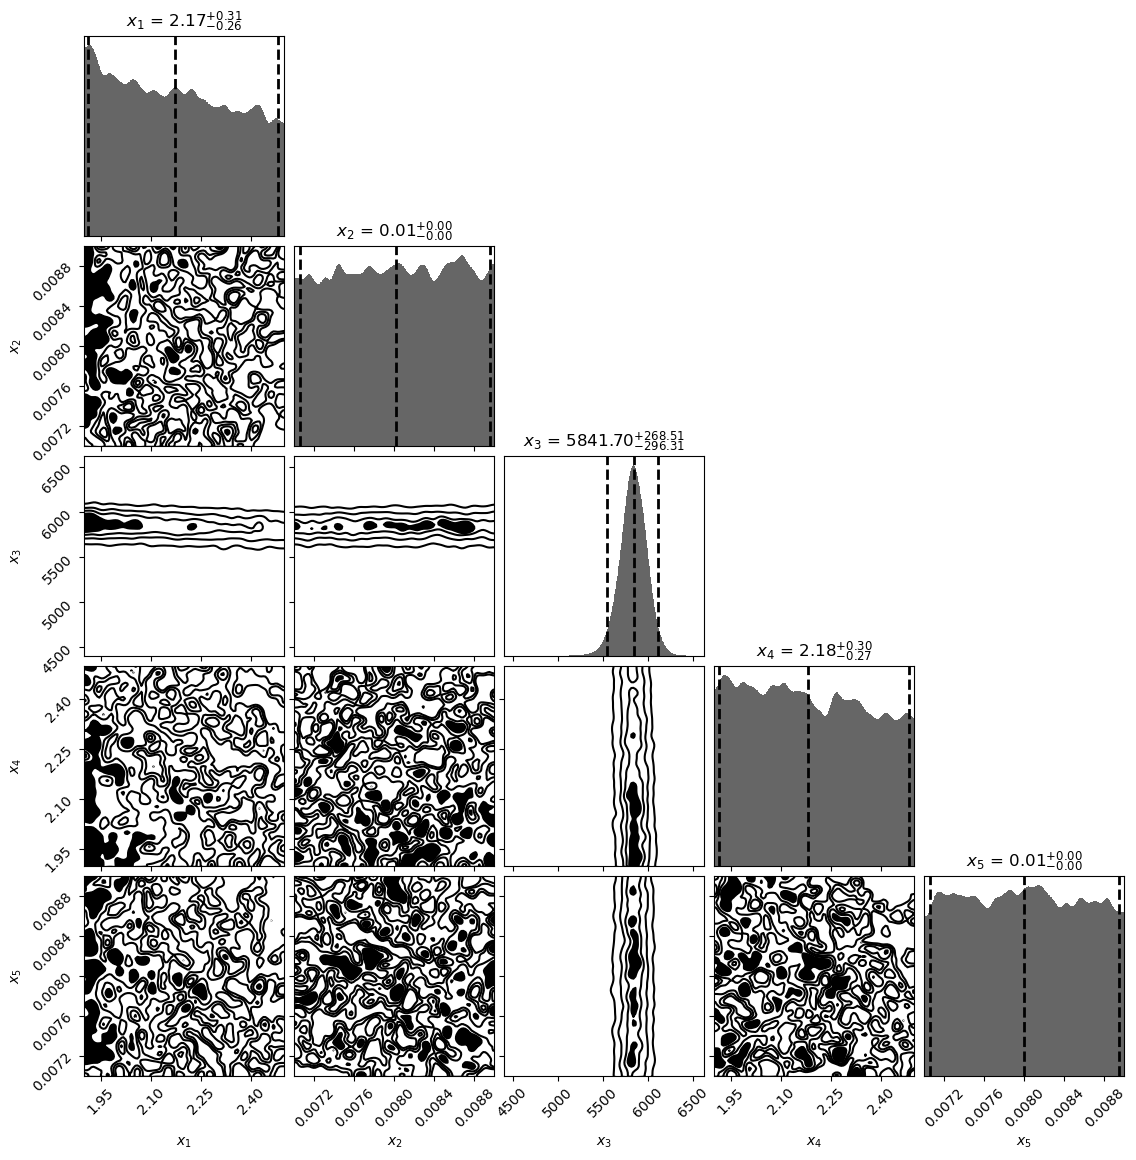

In [573]:
from dynesty import plotting as dyplot

# initialize figure
#fig, axes = plt.subplots(2, 5, figsize=(25, 10))
#axes = axes.reshape((2, 5))  # reshape axes

# add white space
#[a.set_frame_on(False) for a in axes[:, 2]]
#[a.set_xticks([]) for a in axes[:, 2]]
#[a.set_yticks([]) for a in axes[:, 2]]

# plot initial run (res1; left)
fg, ax = dyplot.cornerplot(res1, show_titles=True, dims=range(1,6))#, labels=['$T_{eff}$', '$\log g$'])

# plot extended run (res2; right)
#fg, ax = dyplot.cornerpoints(res2, cmap='viridis', truths=np.zeros(ndim),
#                             kde=False, fig=(fig, axes[:, 3:]))

# Ultimas pruebas

In [17]:
#Binaria Teff diferentes
ra = 80.1041664817600
dec = -70.1857616574200
starname = 'LMC-SC21 40876'
gaia_id = 4657941446199199104 

s = Star(starname, ra, dec, g_id=gaia_id)

mask = s.filter_mask
flxs = s.flux[mask]
flux = s.flux[mask]
errs = s.flux_er[mask]
filts = s.filter_names[mask]
wave = s.wave[mask]


		#####################################
		##             ARIADNE             ##
		#####################################
   spectrAl eneRgy dIstribution bAyesian moDel averagiNg fittEr

			Author : Jose Vines
			Contact : jose . vines at ug . uchile . cl
			Star : LMC-SC21 40876
		*** LOOKING UP ARCHIVAL INFORMATION ***
INFO: Query finished. [astroquery.utils.tap.core]
Warning!: CatalogWarning
Warning message: Invalid parallax found (plx <= 0)
Warning!: CatalogWarning
Warning message: Parameter radius not found! Be advised.
Warning!: CatalogWarning
Warning message: Parameter lum not found! Be advised.
INFO: Query finished. [astroquery.utils.tap.core]
Star not found in catalog TYCHO2.
INFO: Query finished. [astroquery.utils.tap.core]
Star not found in catalog Pan-STARRS.
INFO: Query finished. [astroquery.utils.tap.core]
Star not found in catalog SDSS.
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.uti

(0.1, 6.0)

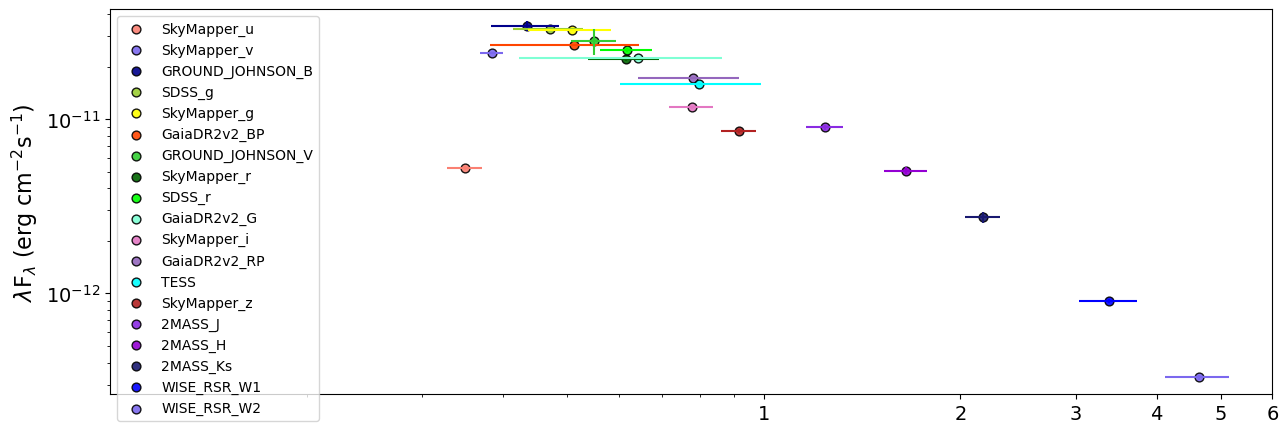

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

ymin = (flxs * wave).min()
ymax = (flxs * wave).max()

f, ax = plt.subplots(figsize=[15,5])

# Model plot
used_f = s.filter_names[mask]

colors = np.array(['tomato', 'indianred', 'tab:red',
            'salmon', 'coral',
            'mediumorchid', 'mediumslateblue', 'tab:blue',
            'darkslateblue', 'darkblue',
            'olivedrab', 'yellowgreen', 'greenyellow', 'yellow',
            'orangered', 'chocolate', 'khaki',
            'limegreen', 'darkgreen', 'lime', 'seagreen', 'lawngreen', 'green',
            'aquamarine', 'turquoise', 'lightseagreen', 'teal', 'cadetblue',
            'tab:pink', 'tab:purple', 'tab:cyan', 'aqua', 'azure', 'dodgerblue',
            'firebrick', 'darkred',
            'blueviolet', 'darkviolet',
            'midnightblue', 'blue',
            'deeppink', 'fuchsia', 'mediumslateblue'])

for c, w, fl, fe, bp, fi in zip(
                colors[mask],
                wave, flxs, errs,
                s.bandpass[mask], filts):
    ax.errorbar(w, fl * w, xerr=bp, yerr=fe * w, fmt='', ecolor=c, marker=None)

    ax.scatter(w, fl * w, edgecolors='black', marker='o', c=c, s=40,
               alpha=.9, label=fi)

ax.set_ylim([ymin * .8, ymax * 1.25])
ax.set_xscale('log', nonpositive='clip')
ax.set_yscale('log', nonpositive='clip')
ax.set_ylabel(r'$\lambda$F$_\lambda$ (erg cm$^{-2}$s$^{-1}$)', fontsize=16)
ax.legend(loc=0)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor')
ax.set_xticks(np.linspace(1, 10, 10))
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.1, 6])

In [32]:
#Teff Cefeida fija, metalicidades fijas, logg variable
edist = ['fixed', evaluate_uniform, 'fixed', evaluate_uniform, evaluate_uniform, 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed']
dists = ['fixed', trans_uniform, 'fixed', trans_uniform, trans_uniform, 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed']
prior = [5300, 1.81, 0.008, 9500, 2.43, 0.008, 48500, 25.3, 26.3, 0.41, 0]
hyper = [(4000,12000),(1.0,3.0),(0.007,0.009),(4000,12000),(1.0,3.0),(0.007,0.009),0,0,0,0, (0,1e-11)]

dsampler = dynesty.DynamicNestedSampler(dynesty_log_like, prior_transform, len(prior), walks=25,
                    bound='multi', sample='rwalk', ptform_args=(prior, dist, hyper))

dsampler.run_nested(dlogz_init=0.5, nlive_batch=500, wt_kwargs={'pfrac': .95})

18683it [00:46, 399.19it/s, batch: 7 | bound: 21 | nc: 1 | ncall: 416432 | eff(%):  4.361 | loglstar: -1211.670 < -1206.343 < -1207.322 | logz: -1221.454 +/-  0.100 | stop:  0.915]      


Summary
niter: 18683
ncall: 344432
eff(%):  4.361
logz: -1221.429 +/-  0.092
[5.30000000e+03 1.00697860e+00 8.00000000e-03 8.57295802e+03
 2.04292510e+00 8.00000000e-03 4.85000000e+04 2.53000000e+01
 2.63000000e+01 4.10000000e-01 0.00000000e+00]


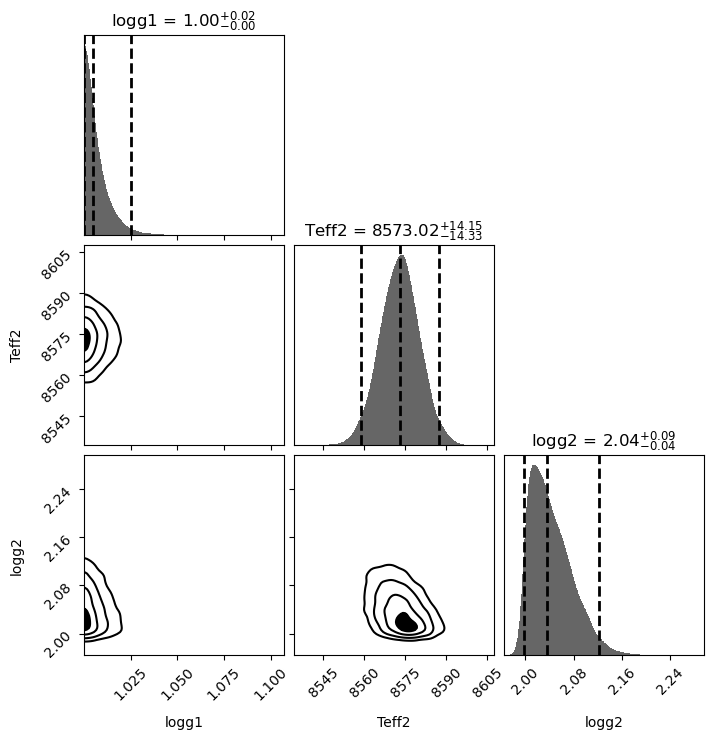

In [33]:
res1 = dsampler.results
res1.summary()

from dynesty import utils as dyfunc
samples, weights = res1.samples, res1.importance_weights()
mean, cov = dyfunc.mean_and_cov(samples, weights)
print(mean)

from dynesty import plotting as dyplot
fg, ax = dyplot.cornerplot(res1, show_titles=True, dims=[1,3,4], labels=['logg1', 'Teff2', 'logg2'], truths=[1.81, 9500, 2.43])

(0.1, 6.0)

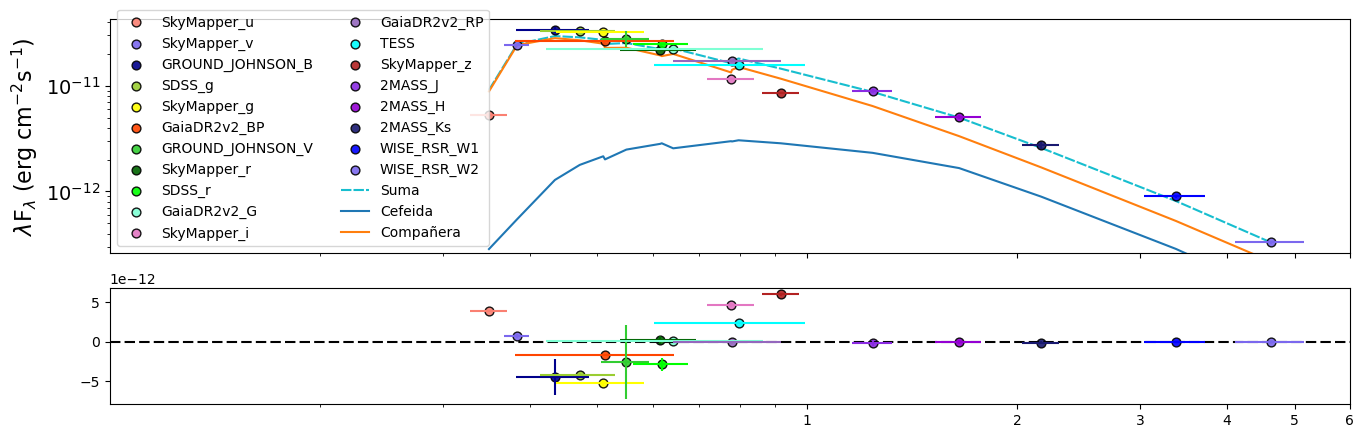

In [34]:
model = binary_model_grid(mean, filts, wave, interpolator, False, extinction.fitzpatrick99)

m1 = np.copy(mean)
m2 = np.copy(mean)
m1[-3] = 0
m2[-4] = 0

model1 = binary_model_grid(m1, filts, wave, interpolator, False, extinction.fitzpatrick99)
model2 = binary_model_grid(m2, filts, wave, interpolator, False, extinction.fitzpatrick99)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

ymin = (flxs * wave).min()
ymax = (flxs * wave).max()

f, (ax, ax2) = plt.subplots(2, 1, height_ratios=[2,1], figsize=[16,5], sharex=True)

# Model plot
used_f = s.filter_names[mask]

colors = np.array(['tomato', 'indianred', 'tab:red',
            'salmon', 'coral',
            'mediumorchid', 'mediumslateblue', 'tab:blue',
            'darkslateblue', 'darkblue',
            'olivedrab', 'yellowgreen', 'greenyellow', 'yellow',
            'orangered', 'chocolate', 'khaki',
            'limegreen', 'darkgreen', 'lime', 'seagreen', 'lawngreen', 'green',
            'aquamarine', 'turquoise', 'lightseagreen', 'teal', 'cadetblue',
            'tab:pink', 'tab:purple', 'tab:cyan', 'aqua', 'azure', 'dodgerblue',
            'firebrick', 'darkred',
            'blueviolet', 'darkviolet',
            'midnightblue', 'blue',
            'deeppink', 'fuchsia', 'mediumslateblue'])

res = (model - flxs) * wave

ax2.axhline(0, dashes=(5,2), color='k')

for c, w, fl, fe, bp, fi, re in zip(
                colors[s.filter_mask],
                s.wave[s.filter_mask], s.flux[s.filter_mask], s.flux_er[s.filter_mask],
                s.bandpass[s.filter_mask], used_f, res):
    ax.errorbar(w, fl * w, xerr=bp, yerr=np.sqrt((fe * w)**2 + mean[-1]**2), fmt='', ecolor=c, marker=None)

    ax.scatter(w, fl * w, edgecolors='black', marker='o', c=c, s=40,
               alpha=.9, label=fi)
    
    ax2.errorbar(w, re, xerr=bp, yerr=np.sqrt((fe * w)**2 + mean[-1]**2), fmt='', ecolor=c, marker=None)
    ax2.scatter(w, re, edgecolors='black', marker='o', c=c, s=40,
               alpha=.9, label=fi)

    
ax.plot(wave, model*wave, dashes=(5,1), label='Suma', zorder=-9)
ax.plot(wave, model1*wave, label='Cefeida', zorder=-9)
ax.plot(wave, model2*wave, label='Compañera', zorder=-9)
    
ax.set_ylim([ymin * .8, ymax * 1.25])
ax.set_xscale('log', nonpositive='clip')
ax.set_yscale('log', nonpositive='clip')
ax.set_ylabel(r'$\lambda$F$_\lambda$ (erg cm$^{-2}$s$^{-1}$)', fontsize=16)
ax.legend(loc=0, ncols=2)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor')
ax.set_xticks(np.linspace(1, 10, 10))
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.1, 6])

In [23]:
#Misma cosa, pero ahora inflando las barras de error...
edist = ['fixed', evaluate_uniform, 'fixed', evaluate_uniform, evaluate_uniform, 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', evaluate_uniform]
dists = ['fixed', trans_uniform, 'fixed', trans_uniform, trans_uniform, 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', trans_uniform]
prior = [5300, 1.81, 0.008, 9500, 2.43, 0.008, 48500, 25.3, 26.3, 0.41, 0]
hyper = [(4000,12000),(1.0,3.0),(0.007,0.009),(4000,12000),(1.0,3.0),(0.007,0.009),0,0,0,0, (0,1e-11)]

dsampler = dynesty.DynamicNestedSampler(dynesty_log_like, prior_transform, len(prior), walks=25,
                    bound='multi', sample='rwalk', ptform_args=(prior, dist, hyper))

dsampler.run_nested(dlogz_init=0.5, nlive_batch=500, wt_kwargs={'pfrac': .95})

13530it [00:32, 413.04it/s, batch: 7 | bound: 18 | nc: 1 | ncall: 286911 | eff(%):  4.526 | loglstar: 462.469 < 467.325 < 466.543 | logz: 461.506 +/-  0.057 | stop:  0.994]         


Summary
niter: 13530
ncall: 214911
eff(%):  4.526
logz: 461.533 +/-  0.052
[5.30000000e+03 1.97059828e+00 8.00000000e-03 8.66633402e+03
 2.44147585e+00 8.00000000e-03 4.85000000e+04 2.53000000e+01
 2.63000000e+01 4.10000000e-01 5.42555626e-12]


(0.1, 6.0)

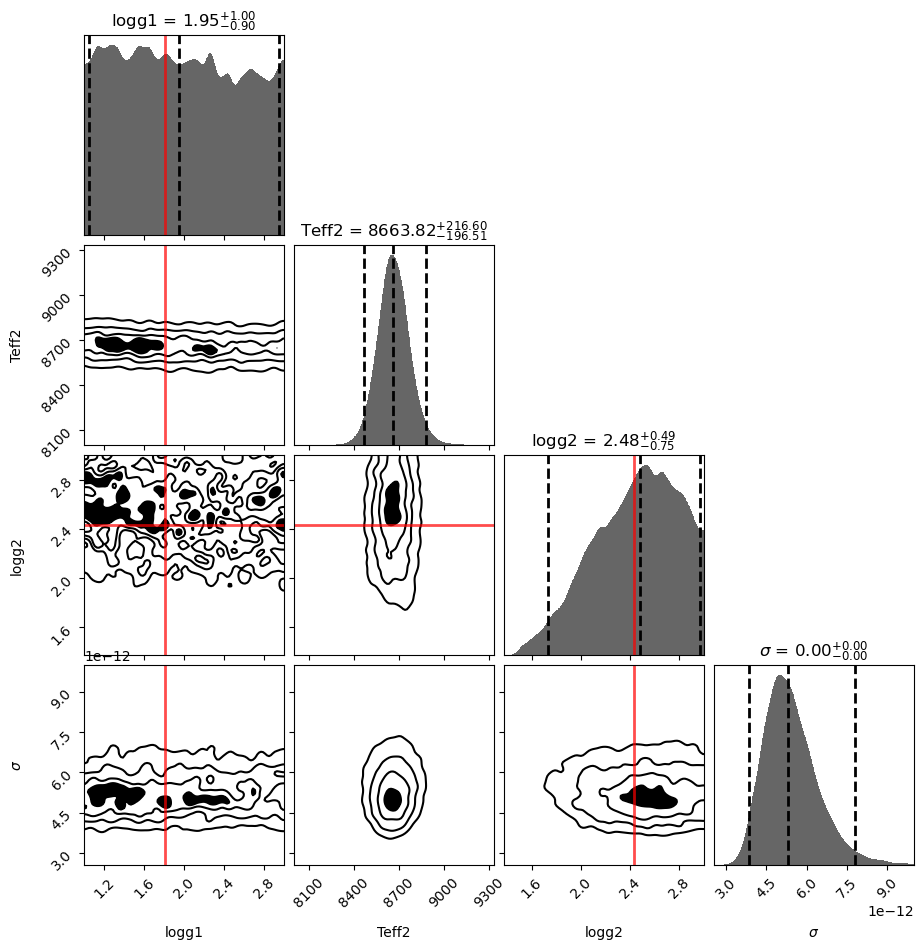

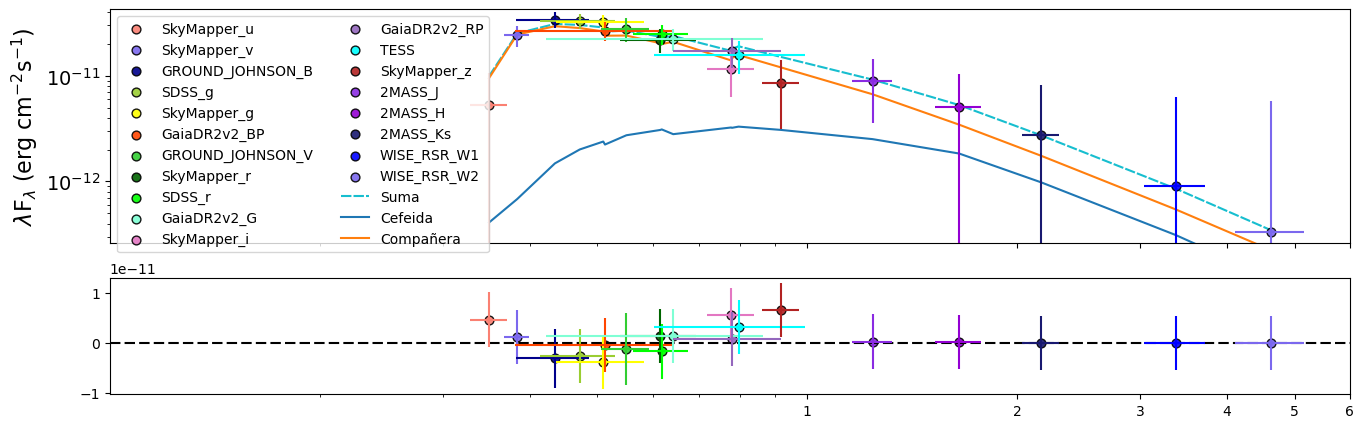

In [28]:
res1 = dsampler.results
res1.summary()

from dynesty import utils as dyfunc
samples, weights = res1.samples, res1.importance_weights()
mean, cov = dyfunc.mean_and_cov(samples, weights)
print(mean)

from dynesty import plotting as dyplot
fg, ax = dyplot.cornerplot(res1, show_titles=True, dims=[1,3,4,-1], labels=['logg1', 'Teff2', 'logg2', '$\sigma$'], 
                           truths=[1.81, 9500, 2.43, 0])

model = binary_model_grid(mean, filts, wave, interpolator, False, extinction.fitzpatrick99)

m1 = np.copy(mean)
m2 = np.copy(mean)
m1[-3] = 0
m2[-4] = 0

model1 = binary_model_grid(m1, filts, wave, interpolator, False, extinction.fitzpatrick99)
model2 = binary_model_grid(m2, filts, wave, interpolator, False, extinction.fitzpatrick99)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

ymin = (flxs * wave).min()
ymax = (flxs * wave).max()

f, (ax, ax2) = plt.subplots(2, 1, height_ratios=[2,1], figsize=[16,5], sharex=True)

# Model plot
used_f = s.filter_names[mask]

colors = np.array(['tomato', 'indianred', 'tab:red',
            'salmon', 'coral',
            'mediumorchid', 'mediumslateblue', 'tab:blue',
            'darkslateblue', 'darkblue',
            'olivedrab', 'yellowgreen', 'greenyellow', 'yellow',
            'orangered', 'chocolate', 'khaki',
            'limegreen', 'darkgreen', 'lime', 'seagreen', 'lawngreen', 'green',
            'aquamarine', 'turquoise', 'lightseagreen', 'teal', 'cadetblue',
            'tab:pink', 'tab:purple', 'tab:cyan', 'aqua', 'azure', 'dodgerblue',
            'firebrick', 'darkred',
            'blueviolet', 'darkviolet',
            'midnightblue', 'blue',
            'deeppink', 'fuchsia', 'mediumslateblue'])

res = (model - flxs) * wave

ax2.axhline(0, dashes=(5,2), color='k')

for c, w, fl, fe, bp, fi, re in zip(
                colors[s.filter_mask],
                s.wave[s.filter_mask], s.flux[s.filter_mask], s.flux_er[s.filter_mask],
                s.bandpass[s.filter_mask], used_f, res):
    ax.errorbar(w, fl * w, xerr=bp, yerr=np.sqrt((fe * w)**2 + mean[-1]**2), fmt='', ecolor=c, marker=None)

    ax.scatter(w, fl * w, edgecolors='black', marker='o', c=c, s=40,
               alpha=.9, label=fi)
    
    ax2.errorbar(w, re, xerr=bp, yerr=np.sqrt((fe * w)**2 + mean[-1]**2), fmt='', ecolor=c, marker=None)
    ax2.scatter(w, re, edgecolors='black', marker='o', c=c, s=40,
               alpha=.9, label=fi)

    
ax.plot(wave, model*wave, dashes=(5,1), label='Suma', zorder=-9)
ax.plot(wave, model1*wave, label='Cefeida', zorder=-9)
ax.plot(wave, model2*wave, label='Compañera', zorder=-9)
    
ax.set_ylim([ymin * .8, ymax * 1.25])
ax.set_xscale('log', nonpositive='clip')
ax.set_yscale('log', nonpositive='clip')
ax.set_ylabel(r'$\lambda$F$_\lambda$ (erg cm$^{-2}$s$^{-1}$)', fontsize=16)
ax.legend(loc=0, ncols=2)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor')
ax.set_xticks(np.linspace(1, 10, 10))
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.1, 6])

In [48]:
#Teff1 fija, logg variables, Av variable, sin sigma
edist = ['fixed', evaluate_uniform, 'fixed', evaluate_uniform, evaluate_uniform, 'fixed', 'fixed', 'fixed', 'fixed', evaluate_uniform, 'fixed']
dists = ['fixed', trans_uniform, 'fixed', trans_uniform, trans_uniform, 'fixed', 'fixed', 'fixed', 'fixed', trans_uniform, 'fixed']
prior = [5300, 1.81, 0.008, 9500, 2.43, 0.008, 48500, 25.3, 26.3, 0.41, 0]
hyper = [(4000,12000),(1.0,3.0),(0.007,0.009),(4000,12000),(1.0,3.0),(0.007,0.009),0,0,0,(0.3, 0.5), (0,1e-11)]

dsampler = dynesty.DynamicNestedSampler(dynesty_log_like, prior_transform, len(prior), walks=25,
                    bound='multi', sample='rwalk', ptform_args=(prior, dist, hyper))

dsampler.run_nested(dlogz_init=0.5, nlive_batch=500, wt_kwargs={'pfrac': .95})

21196it [00:59, 357.09it/s, batch: 5 | bound: 32 | nc: 1 | ncall: 478920 | eff(%):  4.318 | loglstar: -1036.108 < -1029.715 < -1031.261 | logz: -1051.874 +/-  0.142 | stop:  0.965]       


Summary
niter: 21196
ncall: 430920
eff(%):  4.318
logz: -1051.918 +/-  0.123
[5.30000000e+03 1.00695600e+00 8.00000000e-03 8.27843744e+03
 1.99947334e+00 8.00000000e-03 4.85000000e+04 2.53000000e+01
 2.63000000e+01 3.00695017e-01 0.00000000e+00]


(0.1, 6.0)

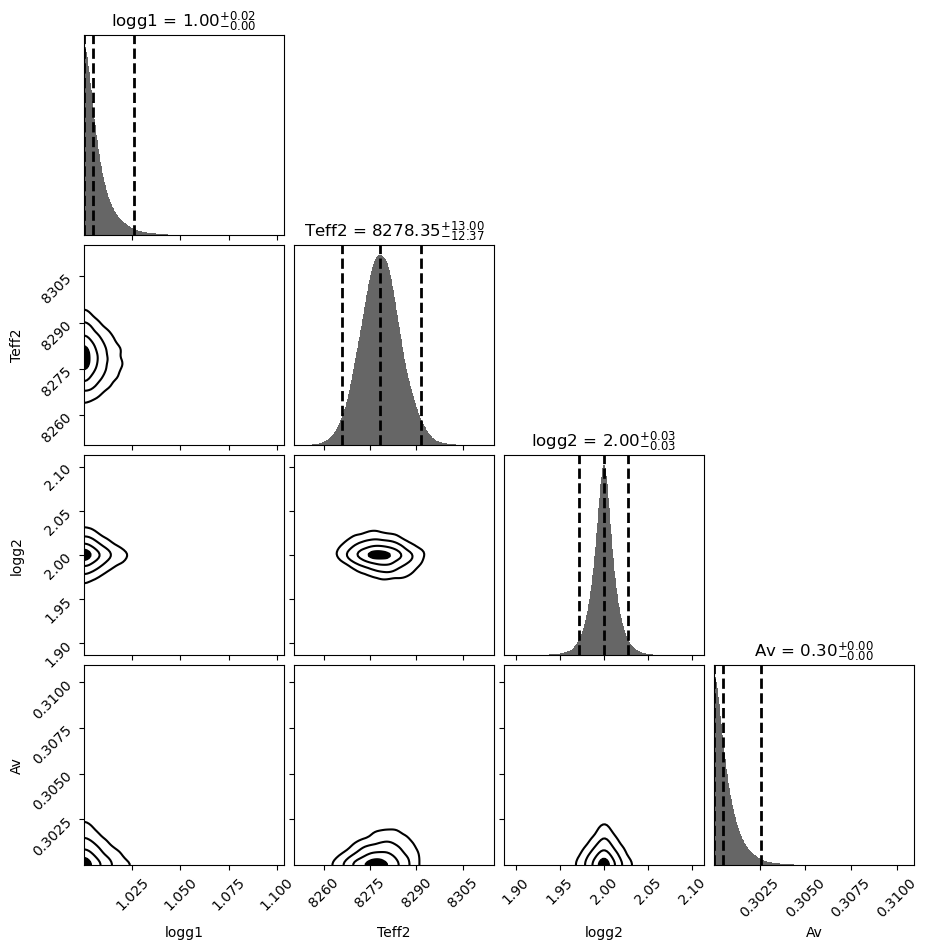

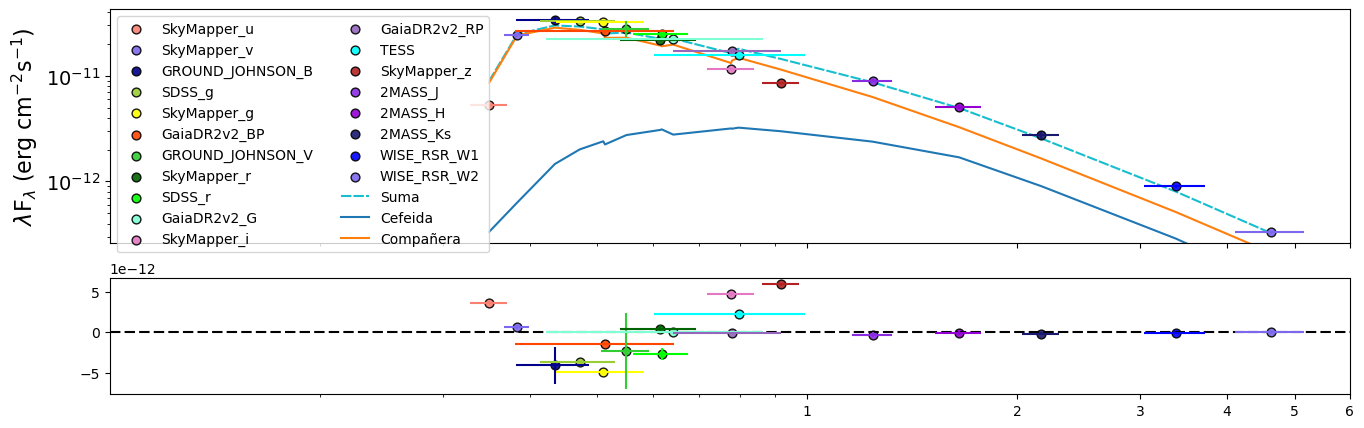

In [49]:
res1 = dsampler.results
res1.summary()

from dynesty import utils as dyfunc
samples, weights = res1.samples, res1.importance_weights()
mean, cov = dyfunc.mean_and_cov(samples, weights)
print(mean)

from dynesty import plotting as dyplot
fg, ax = dyplot.cornerplot(res1, show_titles=True, dims=[1,3,4,-2], labels=['logg1', 'Teff2', 'logg2', 'Av'], 
                           truths=[1.81, 9500, 2.43, 0.41])

model = binary_model_grid(mean, filts, wave, interpolator, False, extinction.fitzpatrick99)

m1 = np.copy(mean)
m2 = np.copy(mean)
m1[-3] = 0
m2[-4] = 0

model1 = binary_model_grid(m1, filts, wave, interpolator, False, extinction.fitzpatrick99)
model2 = binary_model_grid(m2, filts, wave, interpolator, False, extinction.fitzpatrick99)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

ymin = (flxs * wave).min()
ymax = (flxs * wave).max()

f, (ax, ax2) = plt.subplots(2, 1, height_ratios=[2,1], figsize=[16,5], sharex=True)

# Model plot
used_f = s.filter_names[mask]

colors = np.array(['tomato', 'indianred', 'tab:red',
            'salmon', 'coral',
            'mediumorchid', 'mediumslateblue', 'tab:blue',
            'darkslateblue', 'darkblue',
            'olivedrab', 'yellowgreen', 'greenyellow', 'yellow',
            'orangered', 'chocolate', 'khaki',
            'limegreen', 'darkgreen', 'lime', 'seagreen', 'lawngreen', 'green',
            'aquamarine', 'turquoise', 'lightseagreen', 'teal', 'cadetblue',
            'tab:pink', 'tab:purple', 'tab:cyan', 'aqua', 'azure', 'dodgerblue',
            'firebrick', 'darkred',
            'blueviolet', 'darkviolet',
            'midnightblue', 'blue',
            'deeppink', 'fuchsia', 'mediumslateblue'])

res = (model - flxs) * wave

ax2.axhline(0, dashes=(5,2), color='k')

for c, w, fl, fe, bp, fi, re in zip(
                colors[s.filter_mask],
                s.wave[s.filter_mask], s.flux[s.filter_mask], s.flux_er[s.filter_mask],
                s.bandpass[s.filter_mask], used_f, res):
    ax.errorbar(w, fl * w, xerr=bp, yerr=np.sqrt((fe * w)**2 + mean[-1]**2), fmt='', ecolor=c, marker=None)

    ax.scatter(w, fl * w, edgecolors='black', marker='o', c=c, s=40,
               alpha=.9, label=fi)
    
    ax2.errorbar(w, re, xerr=bp, yerr=np.sqrt((fe * w)**2 + mean[-1]**2), fmt='', ecolor=c, marker=None)
    ax2.scatter(w, re, edgecolors='black', marker='o', c=c, s=40,
               alpha=.9, label=fi)

    
ax.plot(wave, model*wave, dashes=(5,1), label='Suma', zorder=-9)
ax.plot(wave, model1*wave, label='Cefeida', zorder=-9)
ax.plot(wave, model2*wave, label='Compañera', zorder=-9)
    
ax.set_ylim([ymin * .8, ymax * 1.25])
ax.set_xscale('log', nonpositive='clip')
ax.set_yscale('log', nonpositive='clip')
ax.set_ylabel(r'$\lambda$F$_\lambda$ (erg cm$^{-2}$s$^{-1}$)', fontsize=16)
ax.legend(loc=0, ncols=2)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor')
ax.set_xticks(np.linspace(1, 10, 10))
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.1, 6])

In [52]:
#Teff1 fija, logg variables, Av variable, ahora inflando errores
edist = ['fixed', evaluate_uniform, 'fixed', evaluate_uniform, evaluate_uniform, 'fixed', 'fixed', 'fixed', 'fixed', evaluate_uniform, evaluate_uniform]
dists = ['fixed', trans_uniform, 'fixed', trans_uniform, trans_uniform, 'fixed', 'fixed', 'fixed', 'fixed', trans_uniform, trans_uniform]
prior = [5300, 1.81, 0.008, 9500, 2.43, 0.008, 48500, 25.3, 26.3, 0.41, 0]
hyper = [(4000,12000),(1.0,3.0),(0.007,0.009),(4000,12000),(1.0,3.0),(0.007,0.009),0,0,0,(0.3, 0.5), (0,1e-11)]

dsampler = dynesty.DynamicNestedSampler(dynesty_log_like, prior_transform, len(prior), walks=25,
                    bound='multi', sample='rwalk', ptform_args=(prior, dist, hyper))

dsampler.run_nested(dlogz_init=0.5, nlive_batch=500, wt_kwargs={'pfrac': .95})

15569it [00:43, 357.87it/s, batch: 8 | bound: 23 | nc: 1 | ncall: 338785 | eff(%):  4.438 | loglstar: 462.473 < 468.183 < 467.056 | logz: 461.679 +/-  0.056 | stop:  0.852]         


Summary
niter: 15569
ncall: 254785
eff(%):  4.438
logz: 461.665 +/-  0.052
[5.30000000e+03 1.99563491e+00 8.00000000e-03 8.56136791e+03
 2.41066574e+00 8.00000000e-03 4.85000000e+04 2.53000000e+01
 2.63000000e+01 3.73237778e-01 5.36421227e-12]


(0.1, 6.0)

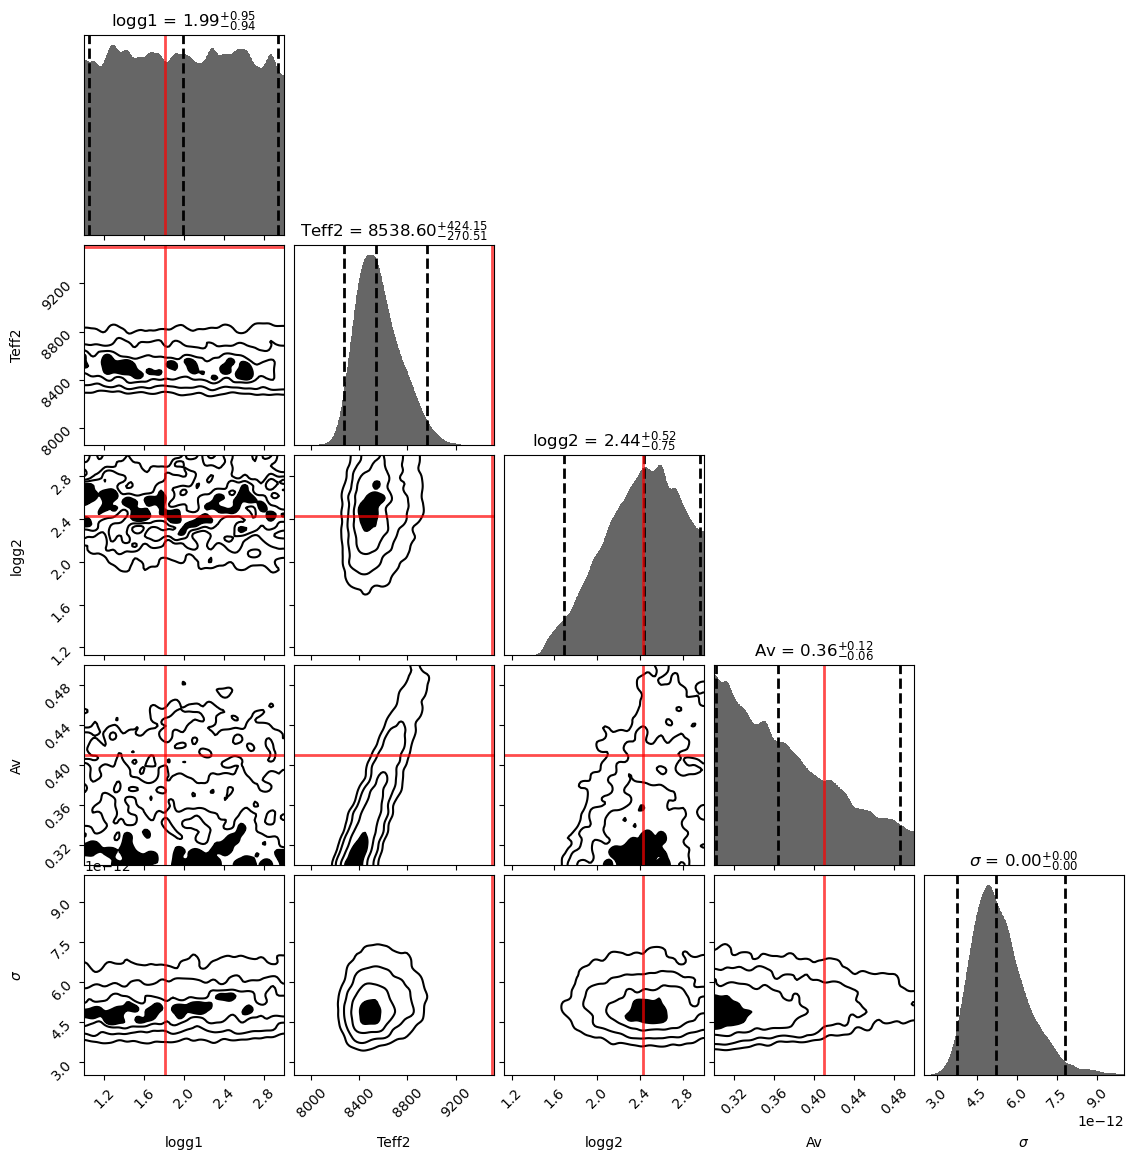

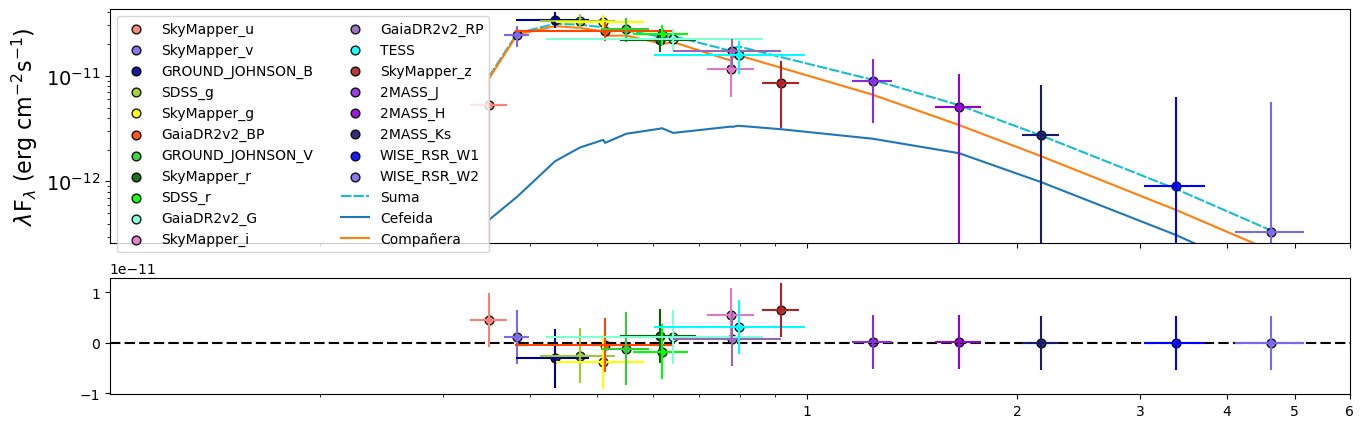

In [53]:
res1 = dsampler.results
res1.summary()

from dynesty import utils as dyfunc
samples, weights = res1.samples, res1.importance_weights()
mean, cov = dyfunc.mean_and_cov(samples, weights)
print(mean)

from dynesty import plotting as dyplot
fg, ax = dyplot.cornerplot(res1, show_titles=True, dims=[1,3,4,-2,-1], labels=['logg1', 'Teff2', 'logg2', 'Av', '$\sigma$'],
                           truths=[1.81, 9500, 2.43, 0.41, 0])

model = binary_model_grid(mean, filts, wave, interpolator, False, extinction.fitzpatrick99)

m1 = np.copy(mean)
m2 = np.copy(mean)
m1[-3] = 0
m2[-4] = 0

model1 = binary_model_grid(m1, filts, wave, interpolator, False, extinction.fitzpatrick99)
model2 = binary_model_grid(m2, filts, wave, interpolator, False, extinction.fitzpatrick99)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

ymin = (flxs * wave).min()
ymax = (flxs * wave).max()

f, (ax, ax2) = plt.subplots(2, 1, height_ratios=[2,1], figsize=[16,5], sharex=True)

# Model plot
used_f = s.filter_names[mask]

colors = np.array(['tomato', 'indianred', 'tab:red',
            'salmon', 'coral',
            'mediumorchid', 'mediumslateblue', 'tab:blue',
            'darkslateblue', 'darkblue',
            'olivedrab', 'yellowgreen', 'greenyellow', 'yellow',
            'orangered', 'chocolate', 'khaki',
            'limegreen', 'darkgreen', 'lime', 'seagreen', 'lawngreen', 'green',
            'aquamarine', 'turquoise', 'lightseagreen', 'teal', 'cadetblue',
            'tab:pink', 'tab:purple', 'tab:cyan', 'aqua', 'azure', 'dodgerblue',
            'firebrick', 'darkred',
            'blueviolet', 'darkviolet',
            'midnightblue', 'blue',
            'deeppink', 'fuchsia', 'mediumslateblue'])

res = (model - flxs) * wave

ax2.axhline(0, dashes=(5,2), color='k')

for c, w, fl, fe, bp, fi, re in zip(
                colors[s.filter_mask],
                s.wave[s.filter_mask], s.flux[s.filter_mask], s.flux_er[s.filter_mask],
                s.bandpass[s.filter_mask], used_f, res):
    ax.errorbar(w, fl * w, xerr=bp, yerr=np.sqrt((fe * w)**2 + mean[-1]**2), fmt='', ecolor=c, marker=None)

    ax.scatter(w, fl * w, edgecolors='black', marker='o', c=c, s=40,
               alpha=.9, label=fi)
    
    ax2.errorbar(w, re, xerr=bp, yerr=np.sqrt((fe * w)**2 + mean[-1]**2), fmt='', ecolor=c, marker=None)
    ax2.scatter(w, re, edgecolors='black', marker='o', c=c, s=40,
               alpha=.9, label=fi)

    
ax.plot(wave, model*wave, dashes=(5,1), label='Suma', zorder=-9)
ax.plot(wave, model1*wave, label='Cefeida', zorder=-9)
ax.plot(wave, model2*wave, label='Compañera', zorder=-9)
    
ax.set_ylim([ymin * .8, ymax * 1.25])
ax.set_xscale('log', nonpositive='clip')
ax.set_yscale('log', nonpositive='clip')
ax.set_ylabel(r'$\lambda$F$_\lambda$ (erg cm$^{-2}$s$^{-1}$)', fontsize=16)
ax.legend(loc=0, ncols=2)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor')
ax.set_xticks(np.linspace(1, 10, 10))
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.1, 6])

In [54]:
#Teff variables, logg variables, Av fija
edist = [evaluate_uniform, evaluate_uniform, 'fixed', evaluate_uniform, evaluate_uniform, 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed']
dists = [trans_uniform, trans_uniform, 'fixed', trans_uniform, trans_uniform, 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed']
prior = [5300, 1.81, 0.008, 9500, 2.43, 0.008, 48500, 25.3, 26.3, 0.41, 0]
hyper = [(4000,12000),(1.0,3.0),(0.007,0.009),(4000,12000),(1.0,3.0),(0.007,0.009),0,0,0,(0.1, 1), (0,1e-11)]

dsampler = dynesty.DynamicNestedSampler(dynesty_log_like, prior_transform, len(prior), walks=25,
                    bound='multi', sample='rwalk', ptform_args=(prior, dist, hyper))

dsampler.run_nested(dlogz_init=0.5, nlive_batch=500, wt_kwargs={'pfrac': .95})

19506it [00:49, 397.43it/s, batch: 6 | bound: 2 | nc: 1 | ncall: 437234 | eff(%):  4.342 | loglstar: -823.441 < -817.593 < -823.007 | logz: -836.720 +/-  0.118 | stop:  0.993]          


Summary
niter: 19506
ncall: 377234
eff(%):  4.342
logz: -836.702 +/-  0.115
[4.00684756e+03 1.08899583e+00 8.00000000e-03 8.77344378e+03
 2.76365735e+00 8.00000000e-03 4.85000000e+04 2.53000000e+01
 2.63000000e+01 4.10000000e-01 0.00000000e+00]


(0.1, 6.0)

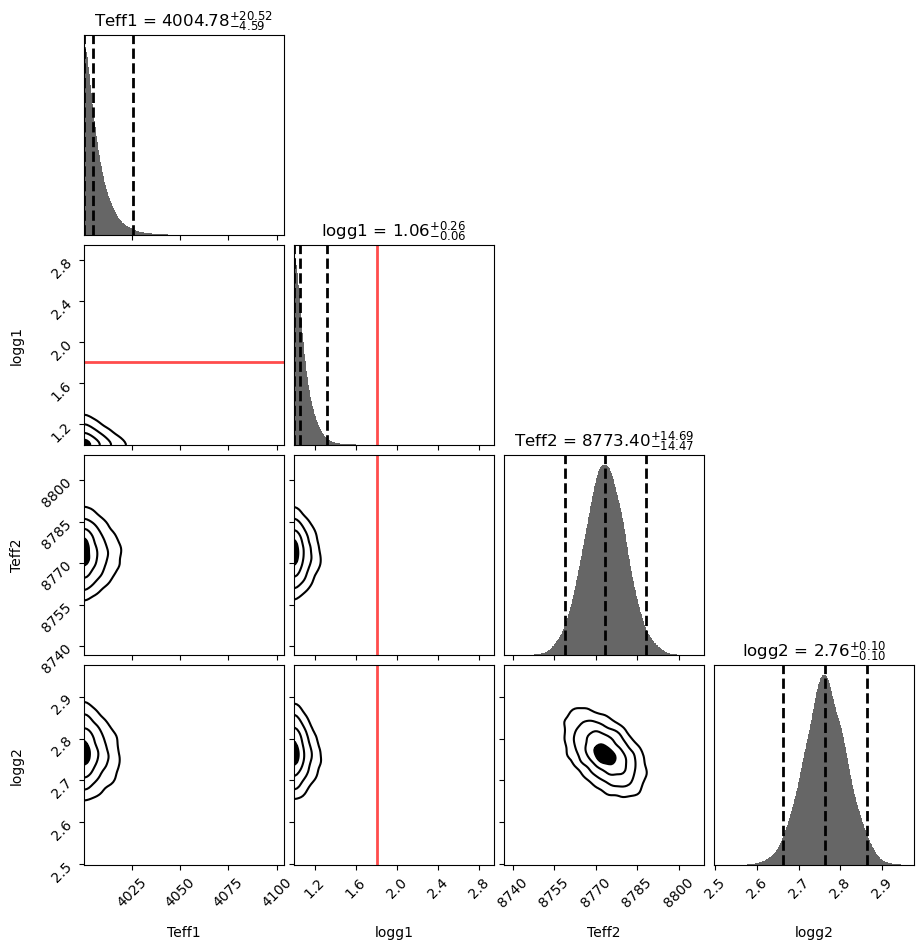

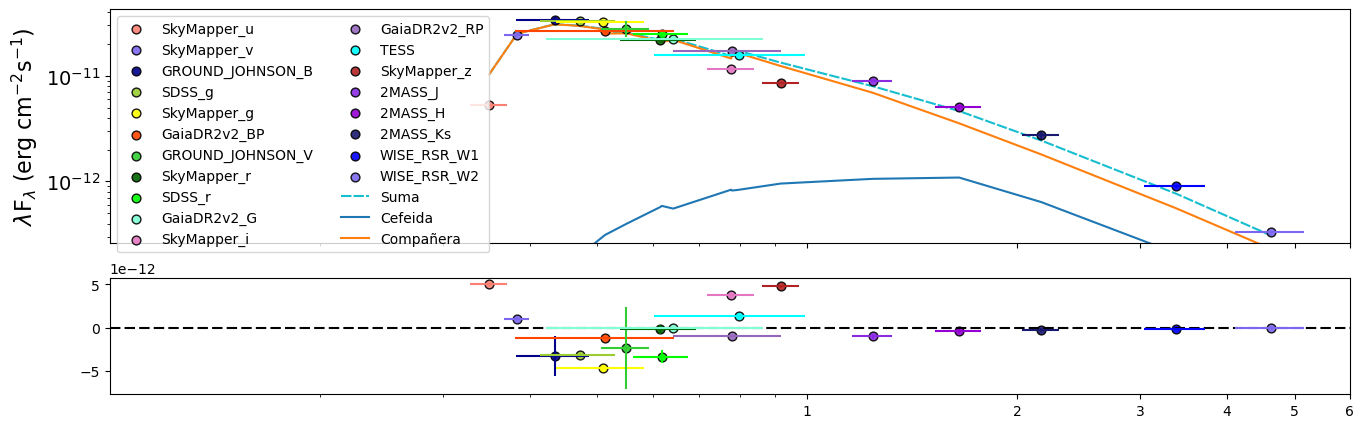

In [55]:
res1 = dsampler.results
res1.summary()

from dynesty import utils as dyfunc
samples, weights = res1.samples, res1.importance_weights()
mean, cov = dyfunc.mean_and_cov(samples, weights)
print(mean)

from dynesty import plotting as dyplot
fg, ax = dyplot.cornerplot(res1, show_titles=True, dims=[0,1,3,4], labels=['Teff1', 'logg1', 'Teff2', 'logg2'], 
                           truths=[5300, 1.81, 9500, 2.43])

model = binary_model_grid(mean, filts, wave, interpolator, False, extinction.fitzpatrick99)

m1 = np.copy(mean)
m2 = np.copy(mean)
m1[-3] = 0
m2[-4] = 0

model1 = binary_model_grid(m1, filts, wave, interpolator, False, extinction.fitzpatrick99)
model2 = binary_model_grid(m2, filts, wave, interpolator, False, extinction.fitzpatrick99)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

ymin = (flxs * wave).min()
ymax = (flxs * wave).max()

f, (ax, ax2) = plt.subplots(2, 1, height_ratios=[2,1], figsize=[16,5], sharex=True)

# Model plot
used_f = s.filter_names[mask]

colors = np.array(['tomato', 'indianred', 'tab:red',
            'salmon', 'coral',
            'mediumorchid', 'mediumslateblue', 'tab:blue',
            'darkslateblue', 'darkblue',
            'olivedrab', 'yellowgreen', 'greenyellow', 'yellow',
            'orangered', 'chocolate', 'khaki',
            'limegreen', 'darkgreen', 'lime', 'seagreen', 'lawngreen', 'green',
            'aquamarine', 'turquoise', 'lightseagreen', 'teal', 'cadetblue',
            'tab:pink', 'tab:purple', 'tab:cyan', 'aqua', 'azure', 'dodgerblue',
            'firebrick', 'darkred',
            'blueviolet', 'darkviolet',
            'midnightblue', 'blue',
            'deeppink', 'fuchsia', 'mediumslateblue'])

res = (model - flxs) * wave

ax2.axhline(0, dashes=(5,2), color='k')

for c, w, fl, fe, bp, fi, re in zip(
                colors[s.filter_mask],
                s.wave[s.filter_mask], s.flux[s.filter_mask], s.flux_er[s.filter_mask],
                s.bandpass[s.filter_mask], used_f, res):
    ax.errorbar(w, fl * w, xerr=bp, yerr=np.sqrt((fe * w)**2 + mean[-1]**2), fmt='', ecolor=c, marker=None)

    ax.scatter(w, fl * w, edgecolors='black', marker='o', c=c, s=40,
               alpha=.9, label=fi)
    
    ax2.errorbar(w, re, xerr=bp, yerr=np.sqrt((fe * w)**2 + mean[-1]**2), fmt='', ecolor=c, marker=None)
    ax2.scatter(w, re, edgecolors='black', marker='o', c=c, s=40,
               alpha=.9, label=fi)

    
ax.plot(wave, model*wave, dashes=(5,1), label='Suma', zorder=-9)
ax.plot(wave, model1*wave, label='Cefeida', zorder=-9)
ax.plot(wave, model2*wave, label='Compañera', zorder=-9)
    
ax.set_ylim([ymin * .8, ymax * 1.25])
ax.set_xscale('log', nonpositive='clip')
ax.set_yscale('log', nonpositive='clip')
ax.set_ylabel(r'$\lambda$F$_\lambda$ (erg cm$^{-2}$s$^{-1}$)', fontsize=16)
ax.legend(loc=0, ncols=2)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor')
ax.set_xticks(np.linspace(1, 10, 10))
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.1, 6])

In [43]:
#Teff variables, logg variables, Av variable
edist = [evaluate_uniform, evaluate_uniform, 'fixed', evaluate_uniform, evaluate_uniform, 'fixed', 'fixed', 'fixed', 'fixed', evaluate_uniform, 'fixed']
dists = [trans_uniform, trans_uniform, 'fixed', trans_uniform, trans_uniform, 'fixed', 'fixed', 'fixed', 'fixed', trans_uniform, 'fixed']
prior = [5300, 1.81, 0.008, 9500, 2.43, 0.008, 48500, 25.3, 26.3, 0.41, 0]
hyper = [(4000,12000),(1.0,3.0),(0.007,0.009),(4000,12000),(1.0,3.0),(0.007,0.009),0,0,0,(0.3, 0.5), (0,1e-11)]

dsampler = dynesty.DynamicNestedSampler(dynesty_log_like, prior_transform, len(prior), walks=25,
                    bound='multi', sample='rwalk', ptform_args=(prior, dist, hyper))

dsampler.run_nested(dlogz_init=0.5, nlive_batch=500, wt_kwargs={'pfrac': .95})

21371it [00:55, 385.18it/s, batch: 5 | bound: 2 | nc: 1 | ncall: 484031 | eff(%):  4.308 | loglstar: -706.727 < -700.204 < -705.991 | logz: -722.336 +/-  0.131 | stop:  0.951]          


Summary
niter: 21371
ncall: 436031
eff(%):  4.308
logz: -722.242 +/-  0.126
[4.01251332e+03 1.22414280e+00 8.00000000e-03 8.49588173e+03
 2.60612353e+00 8.00000000e-03 4.85000000e+04 2.53000000e+01
 2.63000000e+01 3.01131580e-01 0.00000000e+00]


(0.1, 6.0)

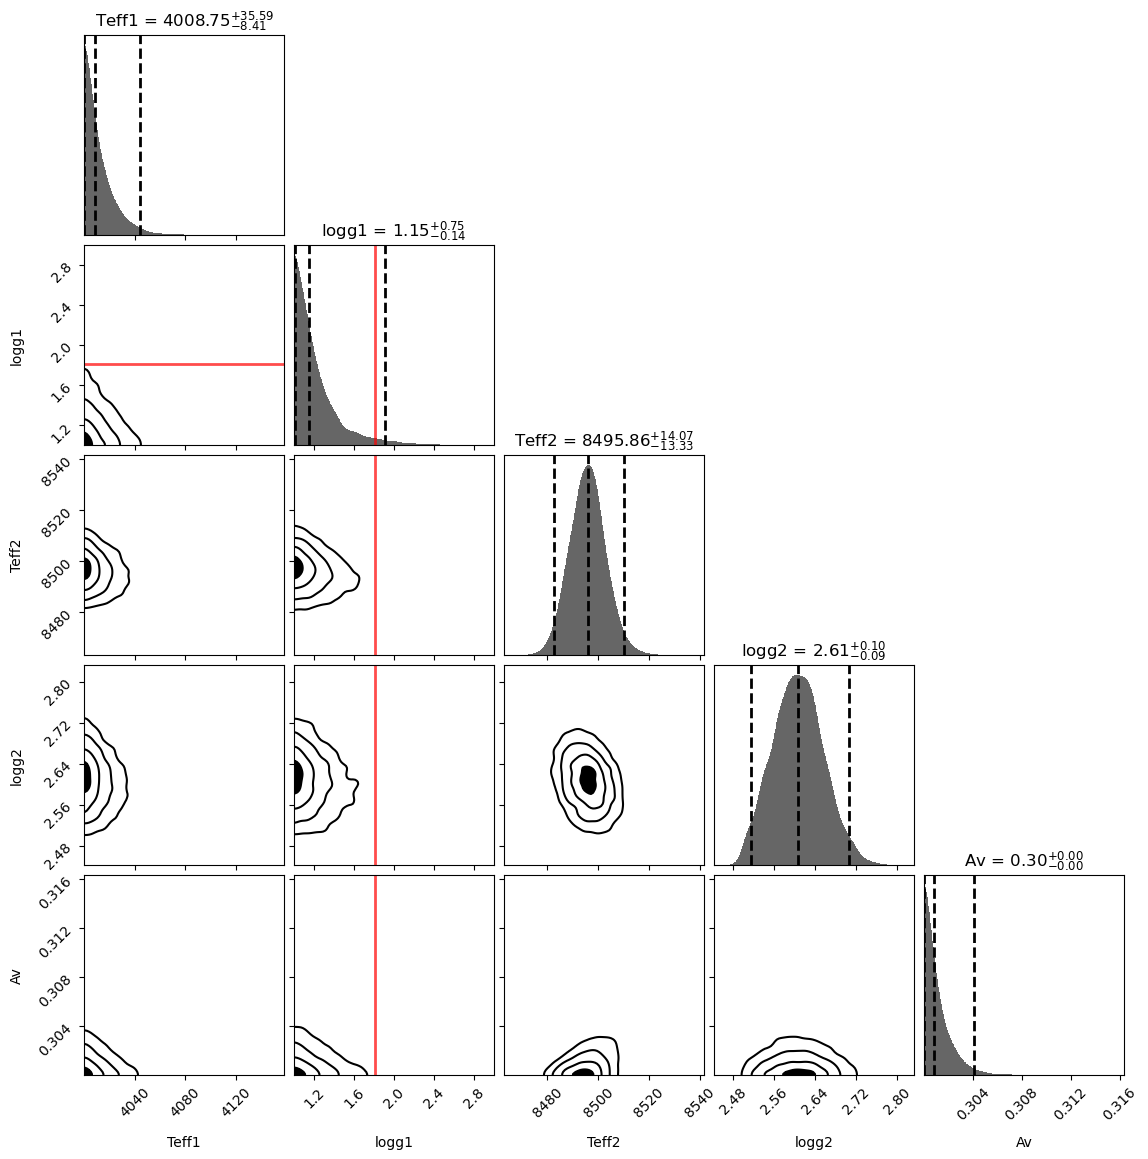

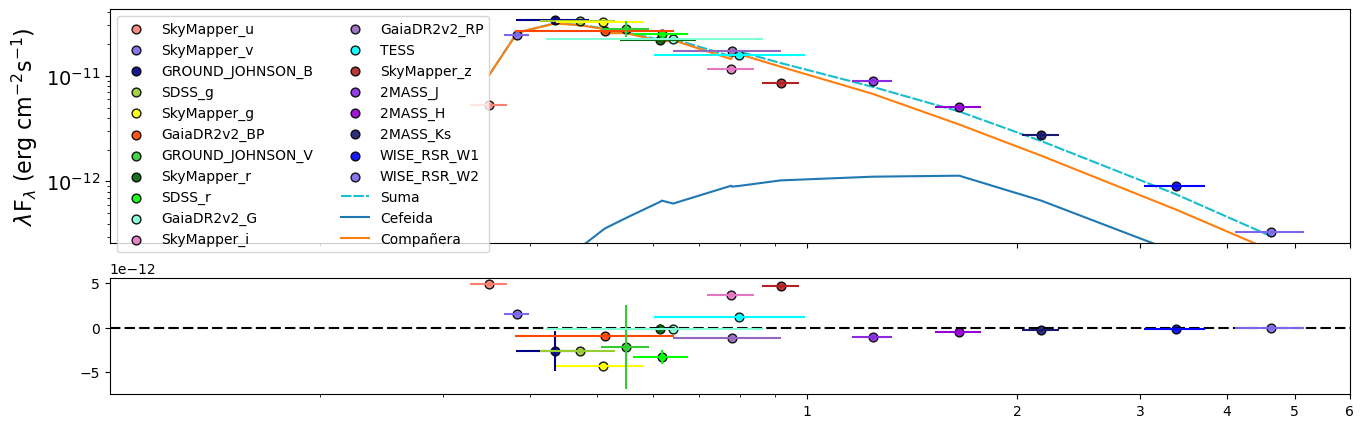

In [44]:
res1 = dsampler.results
res1.summary()

from dynesty import utils as dyfunc
samples, weights = res1.samples, res1.importance_weights()
mean, cov = dyfunc.mean_and_cov(samples, weights)
print(mean)

from dynesty import plotting as dyplot
fg, ax = dyplot.cornerplot(res1, show_titles=True, dims=[0,1,3,4,-2], labels=['Teff1', 'logg1', 'Teff2', 'logg2', 'Av'], 
                           truths=[5300,1.81, 9500, 2.43, 0.41])

model = binary_model_grid(mean, filts, wave, interpolator, False, extinction.fitzpatrick99)

m1 = np.copy(mean)
m2 = np.copy(mean)
m1[-3] = 0
m2[-4] = 0

model1 = binary_model_grid(m1, filts, wave, interpolator, False, extinction.fitzpatrick99)
model2 = binary_model_grid(m2, filts, wave, interpolator, False, extinction.fitzpatrick99)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

ymin = (flxs * wave).min()
ymax = (flxs * wave).max()

f, (ax, ax2) = plt.subplots(2, 1, height_ratios=[2,1], figsize=[16,5], sharex=True)

# Model plot
used_f = s.filter_names[mask]

colors = np.array(['tomato', 'indianred', 'tab:red',
            'salmon', 'coral',
            'mediumorchid', 'mediumslateblue', 'tab:blue',
            'darkslateblue', 'darkblue',
            'olivedrab', 'yellowgreen', 'greenyellow', 'yellow',
            'orangered', 'chocolate', 'khaki',
            'limegreen', 'darkgreen', 'lime', 'seagreen', 'lawngreen', 'green',
            'aquamarine', 'turquoise', 'lightseagreen', 'teal', 'cadetblue',
            'tab:pink', 'tab:purple', 'tab:cyan', 'aqua', 'azure', 'dodgerblue',
            'firebrick', 'darkred',
            'blueviolet', 'darkviolet',
            'midnightblue', 'blue',
            'deeppink', 'fuchsia', 'mediumslateblue'])

res = (model - flxs) * wave

ax2.axhline(0, dashes=(5,2), color='k')

for c, w, fl, fe, bp, fi, re in zip(
                colors[s.filter_mask],
                s.wave[s.filter_mask], s.flux[s.filter_mask], s.flux_er[s.filter_mask],
                s.bandpass[s.filter_mask], used_f, res):
    ax.errorbar(w, fl * w, xerr=bp, yerr=np.sqrt((fe * w)**2 + mean[-1]**2), fmt='', ecolor=c, marker=None)

    ax.scatter(w, fl * w, edgecolors='black', marker='o', c=c, s=40,
               alpha=.9, label=fi)
    
    ax2.errorbar(w, re, xerr=bp, yerr=np.sqrt((fe * w)**2 + mean[-1]**2), fmt='', ecolor=c, marker=None)
    ax2.scatter(w, re, edgecolors='black', marker='o', c=c, s=40,
               alpha=.9, label=fi)

    
ax.plot(wave, model*wave, dashes=(5,1), label='Suma', zorder=-9)
ax.plot(wave, model1*wave, label='Cefeida', zorder=-9)
ax.plot(wave, model2*wave, label='Compañera', zorder=-9)
    
ax.set_ylim([ymin * .8, ymax * 1.25])
ax.set_xscale('log', nonpositive='clip')
ax.set_yscale('log', nonpositive='clip')
ax.set_ylabel(r'$\lambda$F$_\lambda$ (erg cm$^{-2}$s$^{-1}$)', fontsize=16)
ax.legend(loc=0, ncols=2)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor')
ax.set_xticks(np.linspace(1, 10, 10))
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.1, 6])

In [56]:
#Teff variables, logg variables, errores inflados, Av fijo
edist = [evaluate_uniform, evaluate_uniform, 'fixed', evaluate_uniform, evaluate_uniform, 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', evaluate_uniform]
dists = [trans_uniform, trans_uniform, 'fixed', trans_uniform, trans_uniform, 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', trans_uniform]
prior = [5300, 1.81, 0.008, 9500, 2.43, 0.008, 48500, 25.3, 26.3, 0.41, 0]
hyper = [(4000,12000),(1.0,3.0),(0.007,0.009),(4000,12000),(1.0,3.0),(0.007,0.009),0,0,0,(0.1, 1), (0,1e-11)]

dsampler = dynesty.DynamicNestedSampler(dynesty_log_like, prior_transform, len(prior), walks=25,
                    bound='multi', sample='rwalk', ptform_args=(prior, dist, hyper))

dsampler.run_nested(dlogz_init=0.5, nlive_batch=500, wt_kwargs={'pfrac': .95})

16081it [00:41, 385.74it/s, batch: 7 | bound: 29 | nc: 1 | ncall: 350725 | eff(%):  4.433 | loglstar: 462.647 < 469.247 < 467.685 | logz: 461.563 +/-  0.063 | stop:  0.816]       


Summary
niter: 16081
ncall: 278725
eff(%):  4.433
logz: 461.568 +/-  0.057
[7.13477311e+03 1.87732151e+00 8.00000000e-03 7.48869113e+03
 1.86897625e+00 8.00000000e-03 4.85000000e+04 2.53000000e+01
 2.63000000e+01 4.10000000e-01 5.30040671e-12]


(0.1, 6.0)

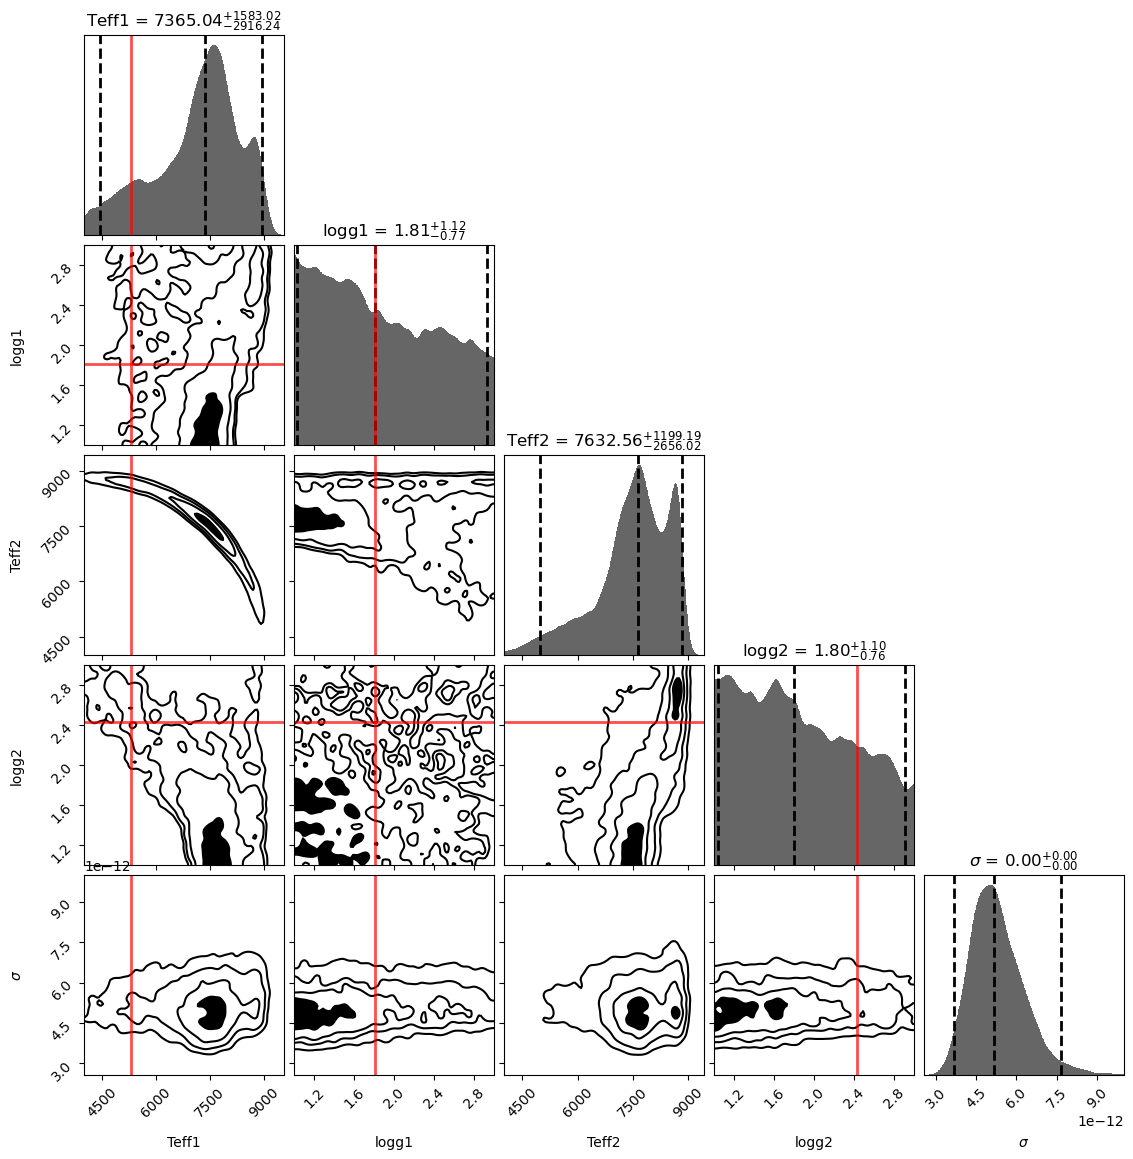

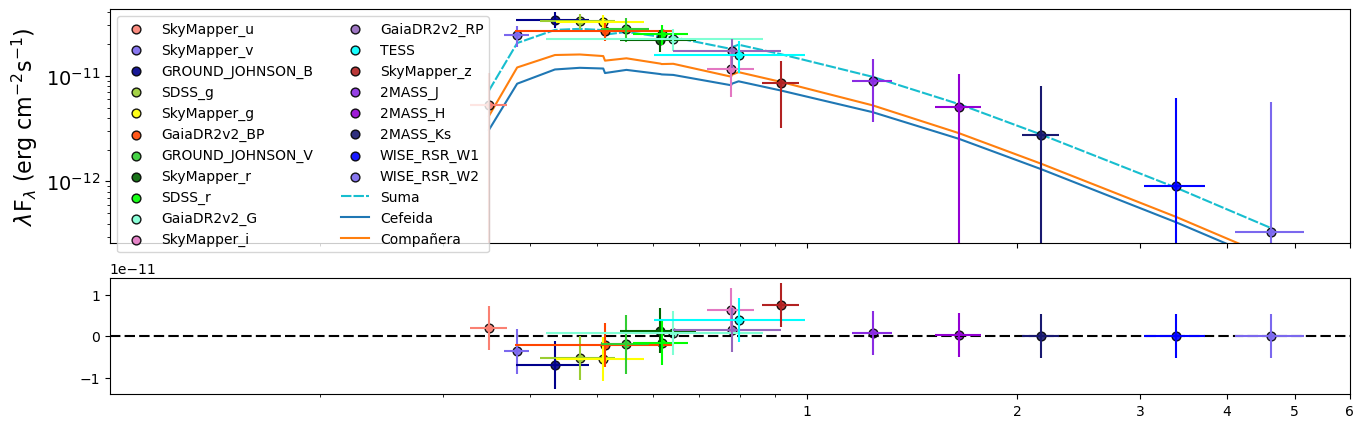

In [57]:
res1 = dsampler.results
res1.summary()

from dynesty import utils as dyfunc
samples, weights = res1.samples, res1.importance_weights()
mean, cov = dyfunc.mean_and_cov(samples, weights)
print(mean)

from dynesty import plotting as dyplot
fg, ax = dyplot.cornerplot(res1, show_titles=True, dims=[0,1,3,4,-1], labels=['Teff1', 'logg1', 'Teff2', 'logg2', '$\sigma$'], 
                           truths=[5300, 1.81, 9500, 2.43, 0])

model = binary_model_grid(mean, filts, wave, interpolator, False, extinction.fitzpatrick99)

m1 = np.copy(mean)
m2 = np.copy(mean)
m1[-3] = 0
m2[-4] = 0

model1 = binary_model_grid(m1, filts, wave, interpolator, False, extinction.fitzpatrick99)
model2 = binary_model_grid(m2, filts, wave, interpolator, False, extinction.fitzpatrick99)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

ymin = (flxs * wave).min()
ymax = (flxs * wave).max()

f, (ax, ax2) = plt.subplots(2, 1, height_ratios=[2,1], figsize=[16,5], sharex=True)

# Model plot
used_f = s.filter_names[mask]

colors = np.array(['tomato', 'indianred', 'tab:red',
            'salmon', 'coral',
            'mediumorchid', 'mediumslateblue', 'tab:blue',
            'darkslateblue', 'darkblue',
            'olivedrab', 'yellowgreen', 'greenyellow', 'yellow',
            'orangered', 'chocolate', 'khaki',
            'limegreen', 'darkgreen', 'lime', 'seagreen', 'lawngreen', 'green',
            'aquamarine', 'turquoise', 'lightseagreen', 'teal', 'cadetblue',
            'tab:pink', 'tab:purple', 'tab:cyan', 'aqua', 'azure', 'dodgerblue',
            'firebrick', 'darkred',
            'blueviolet', 'darkviolet',
            'midnightblue', 'blue',
            'deeppink', 'fuchsia', 'mediumslateblue'])

res = (model - flxs) * wave

ax2.axhline(0, dashes=(5,2), color='k')

for c, w, fl, fe, bp, fi, re in zip(
                colors[s.filter_mask],
                s.wave[s.filter_mask], s.flux[s.filter_mask], s.flux_er[s.filter_mask],
                s.bandpass[s.filter_mask], used_f, res):
    ax.errorbar(w, fl * w, xerr=bp, yerr=np.sqrt((fe * w)**2 + mean[-1]**2), fmt='', ecolor=c, marker=None)

    ax.scatter(w, fl * w, edgecolors='black', marker='o', c=c, s=40,
               alpha=.9, label=fi)
    
    ax2.errorbar(w, re, xerr=bp, yerr=np.sqrt((fe * w)**2 + mean[-1]**2), fmt='', ecolor=c, marker=None)
    ax2.scatter(w, re, edgecolors='black', marker='o', c=c, s=40,
               alpha=.9, label=fi)

    
ax.plot(wave, model*wave, dashes=(5,1), label='Suma', zorder=-9)
ax.plot(wave, model1*wave, label='Cefeida', zorder=-9)
ax.plot(wave, model2*wave, label='Compañera', zorder=-9)
    
ax.set_ylim([ymin * .8, ymax * 1.25])
ax.set_xscale('log', nonpositive='clip')
ax.set_yscale('log', nonpositive='clip')
ax.set_ylabel(r'$\lambda$F$_\lambda$ (erg cm$^{-2}$s$^{-1}$)', fontsize=16)
ax.legend(loc=0, ncols=2)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor')
ax.set_xticks(np.linspace(1, 10, 10))
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.1, 6])

In [58]:
#1ra estrella fija
edist = ['fixed', 'fixed', 'fixed', evaluate_uniform, evaluate_uniform, 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', evaluate_uniform]
dists = ['fixed', 'fixed', 'fixed', trans_uniform, trans_uniform, 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', trans_uniform]
prior = [5300, 1.81, 0.008, 9500, 2.43, 0.008, 48500, 25.3, 26.3, 0.41, 0]
hyper = [(4000,12000),(1.0,3.0),(0.007,0.009),(4000,12000),(1.0,3.0),(0.007,0.009),0,0,0,(0.1, 1), (0,1e-11)]

dsampler = dynesty.DynamicNestedSampler(dynesty_log_like, prior_transform, len(prior), walks=25,
                    bound='multi', sample='rwalk', ptform_args=(prior, dist, hyper))

dsampler.run_nested(dlogz_init=0.5, nlive_batch=500, wt_kwargs={'pfrac': .95})

14026it [00:32, 427.51it/s, batch: 8 | bound: 19 | nc: 1 | ncall: 299306 | eff(%):  4.506 | loglstar: 462.416 < 467.246 < 466.575 | logz: 461.504 +/-  0.056 | stop:  0.939]         


Summary
niter: 14026
ncall: 215306
eff(%):  4.506
logz: 461.508 +/-  0.052
[5.30000000e+03 1.81000000e+00 8.00000000e-03 8.67081953e+03
 2.43937903e+00 8.00000000e-03 4.85000000e+04 2.53000000e+01
 2.63000000e+01 4.10000000e-01 5.45883826e-12]


(0.1, 6.0)

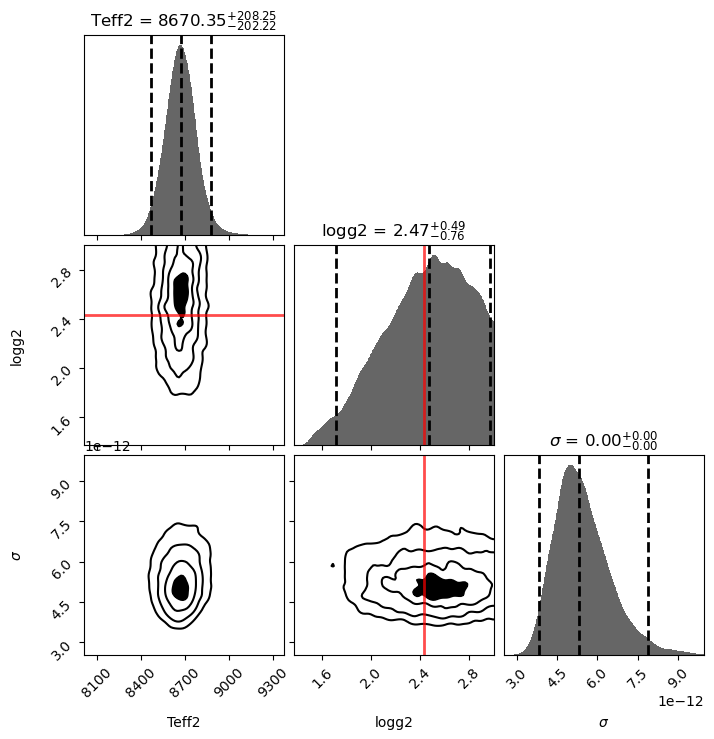

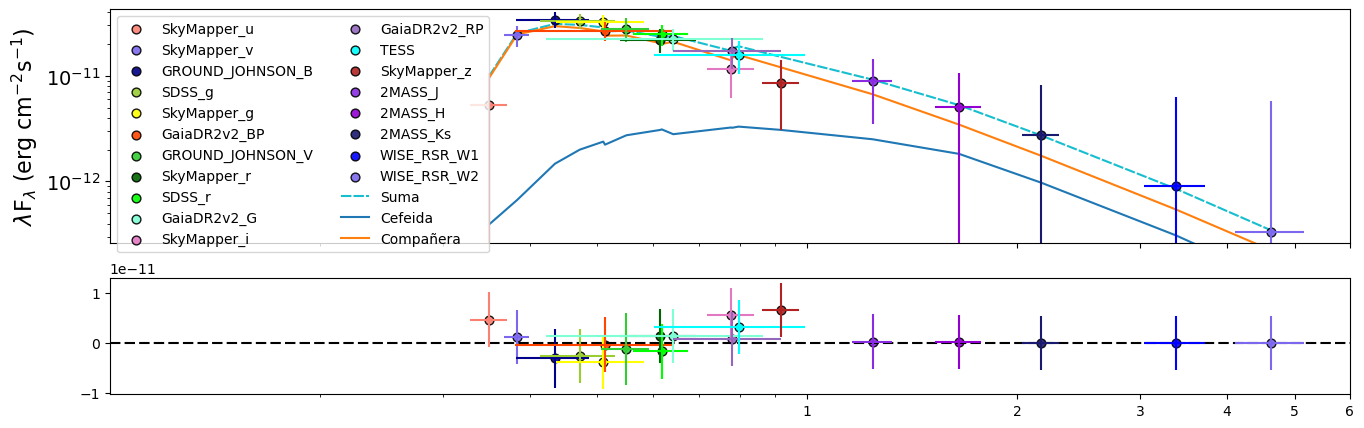

In [61]:
res1 = dsampler.results
res1.summary()

from dynesty import utils as dyfunc
samples, weights = res1.samples, res1.importance_weights()
mean, cov = dyfunc.mean_and_cov(samples, weights)
print(mean)

from dynesty import plotting as dyplot
fg, ax = dyplot.cornerplot(res1, show_titles=True, dims=[3,4,-1], labels=['Teff2', 'logg2', '$\sigma$'], 
                           truths=[9500, 2.43, 0])

model = binary_model_grid(mean, filts, wave, interpolator, False, extinction.fitzpatrick99)

m1 = np.copy(mean)
m2 = np.copy(mean)
m1[-3] = 0
m2[-4] = 0

model1 = binary_model_grid(m1, filts, wave, interpolator, False, extinction.fitzpatrick99)
model2 = binary_model_grid(m2, filts, wave, interpolator, False, extinction.fitzpatrick99)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

ymin = (flxs * wave).min()
ymax = (flxs * wave).max()

f, (ax, ax2) = plt.subplots(2, 1, height_ratios=[2,1], figsize=[16,5], sharex=True)

# Model plot
used_f = s.filter_names[mask]

colors = np.array(['tomato', 'indianred', 'tab:red',
            'salmon', 'coral',
            'mediumorchid', 'mediumslateblue', 'tab:blue',
            'darkslateblue', 'darkblue',
            'olivedrab', 'yellowgreen', 'greenyellow', 'yellow',
            'orangered', 'chocolate', 'khaki',
            'limegreen', 'darkgreen', 'lime', 'seagreen', 'lawngreen', 'green',
            'aquamarine', 'turquoise', 'lightseagreen', 'teal', 'cadetblue',
            'tab:pink', 'tab:purple', 'tab:cyan', 'aqua', 'azure', 'dodgerblue',
            'firebrick', 'darkred',
            'blueviolet', 'darkviolet',
            'midnightblue', 'blue',
            'deeppink', 'fuchsia', 'mediumslateblue'])

res = (model - flxs) * wave

ax2.axhline(0, dashes=(5,2), color='k')

for c, w, fl, fe, bp, fi, re in zip(
                colors[s.filter_mask],
                s.wave[s.filter_mask], s.flux[s.filter_mask], s.flux_er[s.filter_mask],
                s.bandpass[s.filter_mask], used_f, res):
    ax.errorbar(w, fl * w, xerr=bp, yerr=np.sqrt((fe * w)**2 + mean[-1]**2), fmt='', ecolor=c, marker=None)

    ax.scatter(w, fl * w, edgecolors='black', marker='o', c=c, s=40,
               alpha=.9, label=fi)
    
    ax2.errorbar(w, re, xerr=bp, yerr=np.sqrt((fe * w)**2 + mean[-1]**2), fmt='', ecolor=c, marker=None)
    ax2.scatter(w, re, edgecolors='black', marker='o', c=c, s=40,
               alpha=.9, label=fi)

    
ax.plot(wave, model*wave, dashes=(5,1), label='Suma', zorder=-9)
ax.plot(wave, model1*wave, label='Cefeida', zorder=-9)
ax.plot(wave, model2*wave, label='Compañera', zorder=-9)
    
ax.set_ylim([ymin * .8, ymax * 1.25])
ax.set_xscale('log', nonpositive='clip')
ax.set_yscale('log', nonpositive='clip')
ax.set_ylabel(r'$\lambda$F$_\lambda$ (erg cm$^{-2}$s$^{-1}$)', fontsize=16)
ax.legend(loc=0, ncols=2)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor')
ax.set_xticks(np.linspace(1, 10, 10))
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.1, 6])

In [638]:
ra = 221.0582099756900
dec = 05.6053933035500
starname = 'NGTS-5'
gaia_id = 1159042833731813760 

s = Star(starname, ra, dec, g_id=gaia_id)

mask = s.filter_mask
flxs = s.flux[mask]
flux = s.flux[mask]
errs = s.flux_er[mask]
filts = s.filter_names[mask]
wave = s.wave[mask]


		#####################################
		##             ARIADNE             ##
		#####################################
   spectrAl eneRgy dIstribution bAyesian moDel averagiNg fittEr

			Author : Jose Vines
			Contact : jose . vines at ug . uchile . cl
			Star : NGTS-5
		*** LOOKING UP ARCHIVAL INFORMATION ***


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
Star not found in catalog TYCHO2.


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
Looking online for archival magnitudes for star NGTS-5
Checking catalog APASS
Checking catalog All-WISE
Checking catalog Pan-STARRS1
Warning!: CatalogWarning
Warning message: imag magnitude error not found, assigning error.
Checking catalog Gaia DR3
Checking catalog 2MASS
Checking catalog GLIMPSE
Warning!: CatalogWarning
Warning message: Star is not available in catalog GLIMPSE. Skipping
Checking catalog SDSS DR12
Warning!: CatalogWarning
Warning message: SDSS_g magnitude already retrieved. Skipping.
Warning!: CatalogWarning
Warning message: SDSS_r magnitude already retrieved. Skipping.
Warning!: CatalogWarning
Warning message: SDSS_i magnitude already retrieved. Skipping.
Checking catalog GALEX
Warning!: CatalogWarning
Warning message: FUV magnitude not found! Skipping.
Checking catalog TICv8
Warning!: CatalogWarning
Warning message: Star is not available in catalog SkyMapper. Skipping
Warning!: CatalogWarning
Warning message: Star is 

21547it [00:49, 438.91it/s, batch: 6 | bound: 23 | nc: 1 | ncall: 487936 | eff(%):  4.310 | loglstar: -3446.106 < -3440.219 < -3441.586 | logz: -3460.584 +/-  0.121 | stop:  0.867]           


Summary
niter: 21547
ncall: 427936
eff(%):  4.310
logz: -3460.550 +/-  0.111
[5.01066789e+03 4.02801221e+00 2.49348555e-01 9.50000000e+03
 2.43000000e+00 8.00000000e-03 3.07729000e+02 7.50000000e-01
 0.00000000e+00 9.80000000e-02 0.00000000e+00]


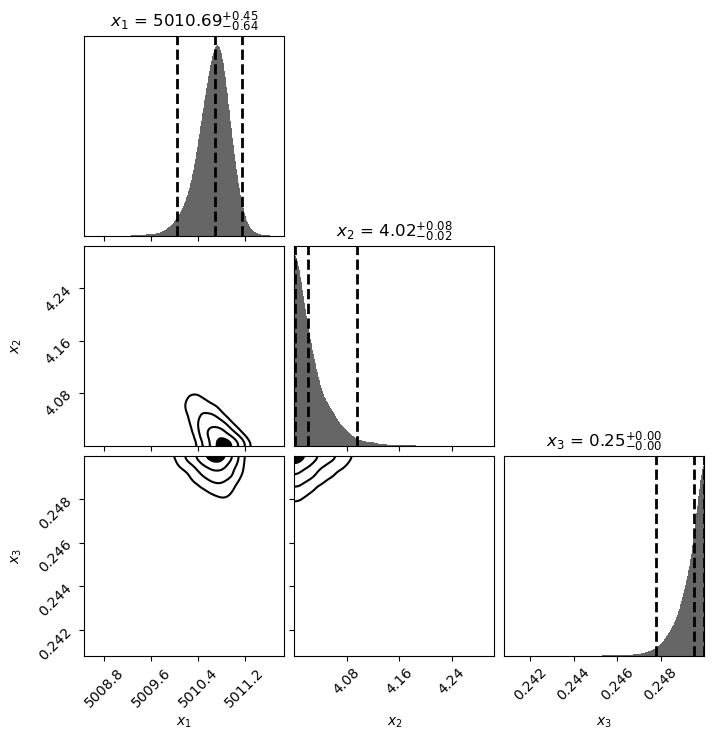

In [650]:
edist = [evaluate_uniform, evaluate_uniform, evaluate_uniform, 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed']
dists = [trans_uniform, trans_uniform, trans_uniform, 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed']
prior = [4500, 5.0, 0.12, 9500, 2.43, 0.008, 307.729, 0.750, 0, 0.098, 0]
hyper = [(4000,12000),(4.0,6.0),(0,0.25),(8500,12000),(1.9,2.5),(0.007,0.009),0,0,(0.5,30),(0,0.1), (0,1e-11)]

dsampler = dynesty.DynamicNestedSampler(dynesty_log_like, prior_transform, len(prior), walks=25,
                    bound='multi', sample='rwalk', ptform_args=(prior, dists, hyper))

dsampler.run_nested(dlogz_init=0.5, nlive_batch=500, wt_kwargs={'pfrac': .95})

res1 = dsampler.results
res1.summary()

from dynesty import utils as dyfunc
samples, weights = res1.samples, res1.importance_weights()
mean, cov = dyfunc.mean_and_cov(samples, weights)
print(mean)

from dynesty import plotting as dyplot
fg, ax = dyplot.cornerplot(res1, show_titles=True, dims=[0,1,2])#, labels=['$T_{eff}$', '$\log g$'])

(0.1, 6.0)

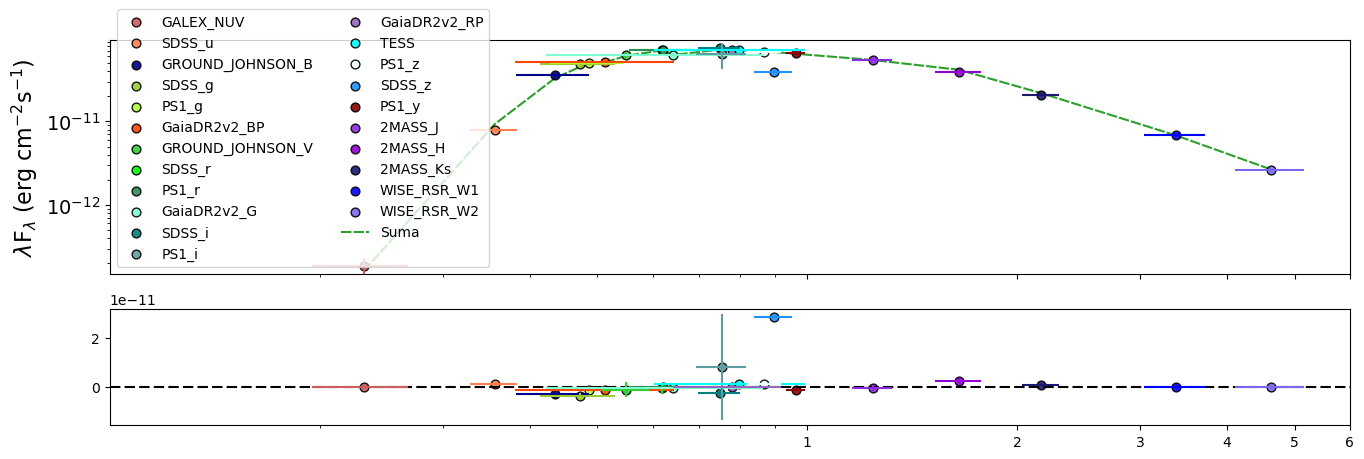

In [651]:
model = binary_model_grid(mean, filts, wave, interpolator, False, extinction.fitzpatrick99)

m1 = np.copy(mean)
m2 = np.copy(mean)
m1[-3] = 0
m2[-4] = 0

model1 = binary_model_grid(m1, filts, wave, interpolator, False, extinction.fitzpatrick99)
model2 = binary_model_grid(m2, filts, wave, interpolator, False, extinction.fitzpatrick99)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

ymin = (flxs * wave).min()
ymax = (flxs * wave).max()

f, (ax, ax2) = plt.subplots(2, 1, height_ratios=[2,1], figsize=[16,5], sharex=True)

# Model plot
used_f = s.filter_names[mask]

colors = np.array(['tomato', 'indianred', 'tab:red',
            'salmon', 'coral',
            'mediumorchid', 'mediumslateblue', 'tab:blue',
            'darkslateblue', 'darkblue',
            'olivedrab', 'yellowgreen', 'greenyellow', 'yellow',
            'orangered', 'chocolate', 'khaki',
            'limegreen', 'darkgreen', 'lime', 'seagreen', 'lawngreen', 'green',
            'aquamarine', 'turquoise', 'lightseagreen', 'teal', 'cadetblue',
            'tab:pink', 'tab:purple', 'tab:cyan', 'aqua', 'azure', 'dodgerblue',
            'firebrick', 'darkred',
            'blueviolet', 'darkviolet',
            'midnightblue', 'blue',
            'deeppink', 'fuchsia', 'mediumslateblue'])

res = (model - flxs) * wave

ax2.axhline(0, dashes=(5,2), color='k')

for c, w, fl, fe, bp, fi, re in zip(
                colors[s.filter_mask],
                s.wave[s.filter_mask], s.flux[s.filter_mask], s.flux_er[s.filter_mask],
                s.bandpass[s.filter_mask], used_f, res):
    ax.errorbar(w, fl * w, xerr=bp, yerr=np.sqrt((fe * w)**2 + mean[-1]**2), fmt='', ecolor=c, marker=None)

    ax.scatter(w, fl * w, edgecolors='black', marker='o', c=c, s=40,
               alpha=.9, label=fi)
    
    ax2.errorbar(w, re, xerr=bp, yerr=np.sqrt((fe * w)**2 + mean[-1]**2), fmt='', ecolor=c, marker=None)
    ax2.scatter(w, re, edgecolors='black', marker='o', c=c, s=40,
               alpha=.9, label=fi)

    
ax.plot(wave, model*wave, dashes=(5,1), label='Suma', zorder=-9)
#ax.plot(wave, model1*wave, label='Cefeida', zorder=-9)
#ax.plot(wave, model2*wave, label='Compañera', zorder=-9)
    
ax.set_ylim([ymin * .8, ymax * 1.25])
ax.set_xscale('log', nonpositive='clip')
ax.set_yscale('log', nonpositive='clip')
ax.set_ylabel(r'$\lambda$F$_\lambda$ (erg cm$^{-2}$s$^{-1}$)', fontsize=16)
ax.legend(loc=0, ncols=2)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor')
ax.set_xticks(np.linspace(1, 10, 10))
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.1, 6])